### Decimation technique

In [2]:
import numpy as np

In [249]:
lattice_constant = 3.0
interaction_range = 1
k_x = 900
k_y = 900
k_xy = 180
k_c = 900
k_c_xy = 180

In [250]:
def ranged_force_constant(lattice_constant, interaction_range, k_x, k_y, k_xy, k_c, k_c_xy, interact_potential="reciproke_squared"):
    """
    Calculate ranged force constants for the 2D Ribbon electrode dependend on which potential is used and on how many neighbors are coupled.
    
    Retruns:
        range_force_constant (list of tuples): Ranged force constant for the 2D lattice
    """

    match interact_potential:

        case "reciproke_squared":
            all_k_x = list(enumerate((k_x * (1 / (i * lattice_constant)**2) for i in range(1, interaction_range + 1))))
            all_k_y = list(enumerate((k_y * (1 / (i * lattice_constant)**2) for i in range(1, interaction_range + 1))))
            all_k_xy =  list(enumerate((k_xy * (1 / (i * lattice_constant)**2) for i in range(1, interaction_range + 1))))
            all_k_c_x = list(enumerate((k_c * (1 / (i * lattice_constant)**2) for i in range(1, interaction_range + 1))))
            all_k_c_xy = list(enumerate((k_c_xy * (1 / (i * lattice_constant)**2) for i in range(1, interaction_range + 1))))
        
        case _:
            raise ValueError("Invalid interaction potential. Choose either 'reciproke_squared', .")
        
    return all_k_x, all_k_y, all_k_xy, all_k_c_x, all_k_c_xy

In [251]:
def build_H_01_new(N_y, interaction_range, ranged_force_constants):
    """
    Build the hessian matrix for the interaction between two princial layers. The interaction range is taken into account.
    """

    N_y = N_y
    interaction_range = interaction_range

    all_k_x, all_k_y, all_k_xy = ranged_force_constants[0:3]
    h01 = np.zeros((2 * N_y * interaction_range, 2 * N_y * interaction_range))
    # build Hessian matrix for the h01 interaction between principal layers
    # rows are A layer atoms, columns are B layer atoms
    
    for i in range(h01.shape[0]):
        for j in range(h01.shape[1]):
            if i % 2 == 0 and j % 2 == 0:
                atomnr_lay1 = np.ceil(float(i + 1) / 2)
                atomnr_lay2 = np.ceil(float(j + 1) / 2)
                
                if atomnr_lay1 == atomnr_lay2:
                    h01[i, j] = -all_k_x[-1][1]
                
                if interaction_range > 1:
                    # for more than next nearest neighbour coupling in x-direction
                    for r in range(interaction_range - 1, -1, -1):
                        
                        if atomnr_lay2 == atomnr_lay1 - r * N_y:
                            h01[i, j] = -all_k_x[-(r + 1)][1]
                    
                    # xy coupling
                    if (interaction_range - 1) * N_y < atomnr_lay1 <= interaction_range * N_y and atomnr_lay2 <= N_y:
                        # edge atoms
                        if atomnr_lay1 == (interaction_range - 1) * N_y + 1 and atomnr_lay2 == 2:
                            h01[i, j] = -all_k_xy[0][1]
                            h01[i + 1, j + 1] = -all_k_xy[0][1]
                        
                        elif atomnr_lay1 == interaction_range * N_y and atomnr_lay2 == N_y - 1:
                            h01[i, j] = -all_k_xy[0][1]
                            h01[i + 1, j + 1] = -all_k_xy[0][1]
                        
                        # middle atoms
                        elif atomnr_lay2 == atomnr_lay1 - (interaction_range - 1) * N_y + 1 or atomnr_lay2 == atomnr_lay1 - (interaction_range - 1) * N_y - 1:
                            h01[i, j] = -all_k_xy[0][1]
                            h01[i + 1, j + 1] = -all_k_xy[0][1]
                    
                else:
                    # edge atoms
                    if atomnr_lay1 == 1 and atomnr_lay2 == 2:
                        h01[i, j] = -all_k_xy[0][1]
                        h01[i + 1, j + 1] = -all_k_xy[0][1]
                    elif atomnr_lay1 == N_y and atomnr_lay2 == N_y - 1:
                        h01[i, j] = -all_k_xy[0][1]
                        h01[i + 1, j + 1] = -all_k_xy[0][1]
                    elif atomnr_lay2 == atomnr_lay1 - 1 or atomnr_lay2 == atomnr_lay1 + 1:
                        h01[i, j] = -all_k_xy[0][1]
                        h01[i + 1, j + 1] = -all_k_xy[0][1]
                    
                    # make matrix now symmetric
                    h01[j, i] = h01[i, j]        
                                                

    return h01

In [301]:
interaction_range = 2
ranged_force_constants = ranged_force_constant(k_x=k_x, k_y=k_y, k_xy=k_xy, k_c=k_c, k_c_xy=k_c_xy, lattice_constant=lattice_constant, interaction_range=interaction_range)
H01 = build_H_01_new(N_y=2, interaction_range=interaction_range, ranged_force_constants=ranged_force_constants)
print(H01)

[[ -25.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.  -25.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [-100.    0.  -20.    0.  -25.    0.    0.    0.]
 [   0.    0.    0.  -20.    0.    0.    0.    0.]
 [ -20.    0. -100.    0.    0.    0.  -25.    0.]
 [   0.  -20.    0.    0.    0.    0.    0.    0.]]


In [302]:
def build_H_00_new(N_y, interaction_range, ranged_force_constants):
    """
    Build the hessian matrix for the first layer. The interaction range is taken into account.

    Returns:
        H_00 (np.ndarray): Hessian matrix of shape (2 * N_y, 2 * N_y)
    """

    N_y = N_y
    interaction_range = interaction_range

    all_k_x, all_k_y, all_k_xy = ranged_force_constants[0:3]

    h00 = np.zeros((2 * N_y * interaction_range, 2 * N_y * interaction_range))

    #build Hessian matrix for the h00 principal surface layer

    for i in range(interaction_range):

        for j in range(i * 2 * N_y, i * 2 * N_y + 2 * N_y):
            
            # diagonal elements x and xy coupling
            if j % 2 == 0:

                atomnr = np.ceil(float(j + 1) / 2)
                
                # ii-coupling
                if atomnr <= N_y and interaction_range > 1:
                    ## first layer
                    h00[j, j] = sum(all_k_x[k][1] for k in range(len(all_k_x)))

                elif atomnr > i * N_y and (i + 1) * N_y == N_y * interaction_range:
                    ## last layer
                    for k in range(interaction_range):
                        if i - k > 0:
                            h00[j, j] += 2 * all_k_x[k][1]
                        else:
                            h00[j, j] += all_k_x[k][1]
                
                elif atomnr > i * N_y and atomnr <= (i + 1) * N_y and (i + 1) * N_y < N_y * interaction_range:
                    for k in range(interaction_range):
                        if i - k > 0:
                            h00[j, j] += 2 * all_k_x[k][1]
                        else:
                            h00[j, j] += all_k_x[k][1]
                            
                for k in range(interaction_range):
                    if j + 2 * (k + 1) * N_y < h00.shape[0]:                    
                        h00[j, j + 2 * (k + 1) * N_y] = -all_k_x[k][1]
                    if j - 2 * (k + 1) * N_y >= 0:
                        h00[j, j - 2 * (k + 1) * N_y] = -all_k_x[k][1]

                # xy-coupling # TODO: do something to take account that only for Ny > 1 possible or leave it to the user?
                if N_y > 1:
                    
                    if j == 0 or j == 2 * N_y - 2:
                        h00[j, j] += all_k_xy[0][1]
                        h00[j + 1, j + 1] += all_k_xy[0][1]

                    elif j < 2 * N_y - 2:
                        h00[j, j] += 2 * all_k_xy[0][1]
                        h00[j + 1, j + 1] += 2 * all_k_xy[0][1]

                    elif (j == i * 2 * N_y or j == i * 2 * N_y + 2 * N_y - 2) and (j != 0 and j != 2 * N_y - 2):
                        h00[j, j] += 2 * all_k_xy[0][1]
                        h00[j + 1, j + 1] += 2 * all_k_xy[0][1]

                    elif j != 0 + i * 2 * N_y and j != i * 2 * N_y + 2 * N_y - 2 and N_y > 2:
                        h00[j, j] += 4 * all_k_xy[0][1]
                        h00[j + 1, j + 1] += 4 * all_k_xy[0][1]
                

            else:
                
                if N_y > 1:
                    # y coupling in the coupling range -> edge layers/atoms
                    if (j == i * 2 * N_y + 1) or (j == i * 2 * N_y + 2 * N_y - 1): 
                        
                        # xy-coupling
                        atomnr = np.ceil(float(j) / 2)

                        if interaction_range > 1:
                            
                            if atomnr < N_y: #and interaction_range > 1:
                                h00[j - 1, int(j - 1 + 2 * (atomnr + N_y + 1) - 2)] = -all_k_xy[0][1]
                                h00[j, int(j - 1 + 2 * (atomnr + N_y + 1) - 1)] = -all_k_xy[0][1]

                            elif atomnr == N_y and interaction_range > 1:
                                h00[j - 1, int(2 * (atomnr + N_y - 1) - 2)] = -all_k_xy[0][1]
                                h00[j, int(2 * (atomnr + N_y - 1) - 1)] = -all_k_xy[0][1]

                            elif atomnr > N_y and interaction_range > 1 and (atomnr == (i + 1) * N_y or atomnr == i * N_y + 1) and atomnr <= N_y * interaction_range - N_y:
                                # N_y == 2 case
                                if atomnr == i * N_y + 1:
                                    h00[j, 2 * int(i * N_y + 1 + N_y + 1) - 1] = -all_k_xy[0][1]
                                    h00[j - 1, 2 * int(i * N_y + 1 + N_y + 1) - 2] = -all_k_xy[0][1]
                                    
                                    h00[j, 2 * int(i * N_y + 1 - N_y + 1) - 1] = -all_k_xy[0][1]
                                    h00[j - 1, 2 * int(i * N_y + 1 - N_y + 1) - 2] = -all_k_xy[0][1]
                                
                                elif atomnr == (i + 1) * N_y:
                                    h00[j, 2 * int((i + 1) * N_y + N_y - 1) - 1] = -all_k_xy[0][1]
                                    h00[j - 1, 2 * int((i + 1) * N_y + N_y - 1) - 2] = -all_k_xy[0][1]
                                    
                                    h00[j, 2 * int((i + 1) * N_y - N_y - 1) - 1] = -all_k_xy[0][1]
                                    h00[j - 1, 2 * int((i + 1) * N_y - N_y - 1) - 2] = -all_k_xy[0][1]
                                    
                            elif (atomnr == N_y * interaction_range - N_y + 1 or atomnr == N_y * interaction_range):
                                
                                if atomnr == N_y * interaction_range - N_y + 1:
                                    h00[j, 2 * int(N_y * interaction_range - N_y + 1 - N_y + 1) - 1] = -all_k_xy[0][1]
                                    h00[j - 1, 2 * int(N_y * interaction_range - N_y + 1 - N_y + 1) - 2] = -all_k_xy[0][1]
                                elif atomnr == N_y * interaction_range:
                                    h00[j, 2 * int(N_y * interaction_range - N_y - 1) - 1] = -all_k_xy[0][1]
                                    h00[j - 1, 2 * int(N_y * interaction_range - N_y - 1) - 2] = -all_k_xy[0][1]



                        #y - coupling
                        if i == 0:
                            h00[j, j] = all_k_y[0][1] + all_k_xy[0][1]
                        else:
                            h00[j, j] = all_k_y[0][1] + 2 * all_k_xy[0][1]

                        if j == 1 + i * 2 * N_y:
                            h00[j, j + 2] = -all_k_y[0][1]
                        else:
                            h00[j, j - 2] = -all_k_y[0][1]

                        if interaction_range >= N_y:
                            for k in range(1, N_y - 1):
                                h00[j, j] += all_k_y[k][1]
                                
                                if j + 2 * (k + 1) < i * 2 * N_y + 2 * N_y:
                                    h00[j, j + 2 * (k + 1)] = -all_k_y[k][1]
                                if j - 2 * (k + 1) >= i * 2 * N_y:
                                    h00[j, j - 2 * (k + 1)] = -all_k_y[k][1]

                        else:
                            for k in range(1, interaction_range):
                                h00[j, j] += all_k_y[k][1]
                            
                                if j + 2 * (k + 1) < i * 2 * N_y + 2 * N_y:
                                    h00[j, j + 2 * (k + 1)] = -all_k_y[k][1]
                                if j - 2 * (k + 1) >= 0 + i * 2 * N_y:
                                    h00[j, j - 2 * (k + 1)] = -all_k_y[k][1]


                    else:
                        
                        atomnr = np.ceil(float(j) / 2)

                        if i == 0:
                            h00[j, j] = 2 * all_k_y[0][1] + 2 * all_k_xy[0][1]
                        else:
                            h00[j, j] = 2 * all_k_y[0][1] + 4 * all_k_xy[0][1]
                        
                        # xy-coupling inner atom, inner layers
                        if interaction_range > 1:
                            
                            if atomnr < N_y: #and interaction_range > 1:
                                ## first layer
                                # first atom
                                h00[j - 1, int(2 * (atomnr + N_y - 1)) - 2] = -all_k_xy[0][1]
                                h00[j, int(2 * (atomnr + N_y - 1)) - 1] = -all_k_xy[0][1]

                                #second atom
                                h00[j - 1, int(2 * (atomnr + N_y + 1)) - 2] = -all_k_xy[0][1]
                                h00[j, int(2 * (atomnr + N_y + 1)) - 1] = -all_k_xy[0][1]

                            elif atomnr > i * N_y and (i + 1) * N_y == N_y * interaction_range:
                                ## last layer
                                # first atom
                                h00[j - 1, int(2 * (atomnr - N_y - 1)) - 2] = -all_k_xy[0][1]
                                h00[j, int(2 * (atomnr - N_y - 1)) - 1] = -all_k_xy[0][1]

                                # second atom
                                h00[j - 1, int(2 * (atomnr - N_y + 1)) - 2] = -all_k_xy[0][1]
                                h00[j, int(2 * (atomnr - N_y + 1)) - 1] = -all_k_xy[0][1]
                            
                            elif atomnr > i * N_y and atomnr < (i + 1) * N_y and (i + 1) * N_y < N_y * interaction_range:
                                ## layer before
                                # first atom
                                h00[j - 1, int(2 * (atomnr - N_y - 1)) - 2] = -all_k_xy[0][1]
                                h00[j, int(2 * (atomnr - N_y - 1)) - 1] = -all_k_xy[0][1]
                                # second atom
                                h00[j - 1, int(2 * (atomnr - N_y + 1)) - 2] = -all_k_xy[0][1]
                                h00[j, int(2 * (atomnr - N_y + 1)) - 1] = -all_k_xy[0][1]

                                ## layer after
                                # first atom
                                h00[j - 1, int(2 * (atomnr + N_y - 1)) - 2] = -all_k_xy[0][1]
                                h00[j, int(2 * (atomnr + N_y - 1)) - 1] = -all_k_xy[0][1]
                                # second atom
                                h00[j - 1, int(2 * (atomnr + N_y + 1)) - 2] = -all_k_xy[0][1]
                                h00[j, int(2 * (atomnr + N_y + 1)) - 1] = -all_k_xy[0][1]

                            

                        if j + 2 < i * 2 * N_y + 2 * N_y:
                            h00[j, j + 2] = -all_k_y[0][1]
                        if j - 2 >= 0 + i * 2 * N_y:
                            h00[j, j - 2] = -all_k_y[0][1]


                        if interaction_range >= N_y:
                            for k in range(1, N_y - 1):
                                if atomnr - k - 1 > i * N_y and atomnr + k < i * N_y + N_y:
                                    h00[j, j] += 2 * all_k_y[k][1]
                                    
                                elif (atomnr - k - 1 <= i * N_y and atomnr + k < i * N_y + N_y) or (atomnr - k - 1 > i * N_y and atomnr + k >= i * N_y + N_y):
                                    h00[j, j] += all_k_y[k][1]
                                
                                if j + 2 * (k + 1) < i * 2 * N_y + 2 * N_y:
                                    h00[j, j + 2 * (k + 1)] = -all_k_y[k][1]
                                if j - 2 * (k + 1) > i * 2 * N_y:
                                    h00[j, j - 2 * (k + 1)] = -all_k_y[k][1]

                        else:
                            for k in range(1, interaction_range):
                                if atomnr - k - 1 > i * N_y and atomnr + k < N_y + i * N_y:#N_y * interaction_range:
                                    h00[j, j] += 2 * all_k_y[k][1]
                                elif (atomnr - k - 1 <= i * N_y and atomnr + k < i * N_y + N_y) or (atomnr - k - 1 > i * N_y and atomnr + k >= i * N_y + N_y):
                                    h00[j, j] += all_k_y[k][1]
                                
                                if j + 2 * (k + 1) < i * 2 * N_y + 2 * N_y:
                                    h00[j, j + 2 * (k + 1)] = -all_k_y[k][1]
                                if j - 2 * (k + 1) >= 0 + i * 2 * N_y:
                                    h00[j, j - 2 * (k + 1)] = -all_k_y[k][1]

    return h00

In [303]:
interaction_range = 2
ranged_force_constants = ranged_force_constant(k_x=k_x, k_y=k_y, k_xy=k_xy, k_c=k_c, k_c_xy=k_c_xy, lattice_constant=lattice_constant, interaction_range=interaction_range)
H00 = build_H_00_new(N_y=2, interaction_range=interaction_range, ranged_force_constants=ranged_force_constants)
print(ranged_force_constants, '\n')
print(H00)

([(0, 100.0), (1, 25.0)], [(0, 100.0), (1, 25.0)], [(0, 20.0), (1, 5.0)], [(0, 100.0), (1, 25.0)], [(0, 20.0), (1, 5.0)]) 

[[ 145.    0.    0.    0. -100.    0.  -20.    0.]
 [   0.  120.    0. -100.    0.    0.    0.  -20.]
 [   0.    0.  145.    0.  -20.    0. -100.    0.]
 [   0. -100.    0.  120.    0.  -20.    0.    0.]
 [-100.    0.  -20.    0.  265.    0.    0.    0.]
 [   0.    0.    0.  -20.    0.  140.    0. -100.]
 [ -20.    0. -100.    0.    0.    0.  265.    0.]
 [   0.  -20.    0.    0.    0. -100.    0.  140.]]


In [304]:
def build_H_NN_new(N_y, interaction_range, ranged_force_constants):
    """
    Build up an actual bulk layer of the electrode. The coupling includes options for x, y and xy coupling. The coupling range is defined by the parameter interaction_range.
    """

    N_y = N_y
    interaction_range = interaction_range

    all_k_x, all_k_y, all_k_xy = ranged_force_constants[0:3]

    hNN = np.zeros((2 * N_y * interaction_range, 2 * N_y * interaction_range))
    #build Hessian matrix for the hNN principal bulklayer

    for i in range(interaction_range):

        for j in range(i * 2 * N_y, i * 2 * N_y + 2 * N_y):
            
            # diagonal elements x and xy coupling
            if j % 2 == 0:
                
                atomnr = np.ceil(float(j + 1) / 2)
                
                # ii-coupling
                hNN[j, j] = sum(2 * all_k_x[k][1] for k in range(len(all_k_x))) 


                for k in range(interaction_range):
                    if j + 2 * (k + 1) * N_y < hNN.shape[0]:                    
                        hNN[j, j + 2 * (k + 1) * N_y] = -all_k_x[k][1]
                    if j - 2 * (k + 1) * N_y >= 0:
                        hNN[j, j - 2 * (k + 1) * N_y] = -all_k_x[k][1]

                # ij-coupling in h01

                # xy-coupling
                if N_y > 1:
                    
                    if j == i * 2 * N_y or j == i * 2 * N_y + 2 * N_y - 2:
                        hNN[j, j] += 2 * all_k_xy[0][1]
                        hNN[j + 1, j + 1] += 2 * all_k_xy[0][1]

                    if j != 0 + i * 2 * N_y and j != i * 2 * N_y + 2 * N_y - 2 and N_y > 2:
                        hNN[j, j] += 4 * all_k_xy[0][1]
                        hNN[j + 1, j + 1] += 4 * all_k_xy[0][1]
                

            else:
                if N_y > 1:
                    # y coupling in the coupling range -> edge layers
                    if (j == i * 2 * N_y + 1) or (j == i * 2 * N_y + 2 * N_y - 1): 
                        
                        # xy-coupling
                        atomnr = np.ceil(float(j) / 2)

                        if interaction_range > 1:
                            
                            if atomnr < N_y:# and interaction_range > 1:
                                hNN[j - 1, int(j - 1 + 2 * (atomnr + N_y + 1) - 2)] = -all_k_xy[0][1]
                                hNN[j, int(j - 1 + 2 * (atomnr + N_y + 1) - 1)] = -all_k_xy[0][1]

                            elif atomnr ==  N_y and interaction_range > 1:
                                hNN[j - 1, int(2 * (atomnr + N_y - 1) - 2)] = -all_k_xy[0][1]
                                hNN[j, int(2 * (atomnr + N_y - 1) - 1)] = -all_k_xy[0][1]

                            
                            elif atomnr > N_y and interaction_range > 1 and (atomnr == (i + 1) * N_y or atomnr == i * N_y + 1) and atomnr <= N_y * interaction_range - N_y:
                                # N_y == 2 case
                                if atomnr == i * N_y + 1:
                                    hNN[j, 2 * int(i * N_y + 1 + N_y + 1) - 1] = -all_k_xy[0][1]
                                    hNN[j - 1, 2 * int(i * N_y + 1 + N_y + 1) - 2] = -all_k_xy[0][1]
                                    
                                    hNN[j, 2 * int(i * N_y + 1 - N_y + 1) - 1] = -all_k_xy[0][1]
                                    hNN[j - 1, 2 * int(i * N_y + 1 - N_y + 1) - 2] = -all_k_xy[0][1]
                                
                                elif atomnr == (i + 1) * N_y:
                                    hNN[j, 2 * int((i + 1) * N_y + N_y - 1) - 1] = -all_k_xy[0][1]
                                    hNN[j - 1, 2 * int((i + 1) * N_y + N_y - 1) - 2] = -all_k_xy[0][1]
                                    
                                    hNN[j, 2 * int((i + 1) * N_y - N_y - 1) - 1] = -all_k_xy[0][1]
                                    hNN[j - 1, 2 * int((i + 1) * N_y - N_y - 1) - 2] = -all_k_xy[0][1]
                                    
                            elif (atomnr == N_y * interaction_range - N_y + 1 or atomnr == N_y * interaction_range):
                                if atomnr == N_y * interaction_range - N_y + 1:
                                    hNN[j, 2 * int(N_y * interaction_range - N_y + 1 - N_y + 1) - 1] = -all_k_xy[0][1]
                                    hNN[j - 1, 2 * int(N_y * interaction_range - N_y + 1 - N_y + 1) - 2] = -all_k_xy[0][1]
                                elif atomnr == N_y * interaction_range:
                                    hNN[j, 2 * int(N_y * interaction_range - N_y - 1) - 1] = -all_k_xy[0][1]
                                    hNN[j - 1, 2 * int(N_y * interaction_range - N_y - 1) - 2] = -all_k_xy[0][1]


                        hNN[j, j] = all_k_y[0][1] + 2 * all_k_xy[0][1]

                        if j == 1 + i * 2 * N_y:
                            hNN[j, j + 2] = -all_k_y[0][1]
                        else:
                            hNN[j, j - 2] = -all_k_y[0][1]

                        if interaction_range >= N_y:
                            for k in range(1, N_y - 1):
                                hNN[j, j] += all_k_y[k][1]
                                
                                if j + 2 * (k + 1) < i * 2 * N_y + 2 * N_y:
                                    hNN[j, j + 2 * (k + 1)] = -all_k_y[k][1]
                                if j - 2 * (k + 1) >= i * 2 * N_y:
                                    hNN[j, j - 2 * (k + 1)] = -all_k_y[k][1]

                        else:
                            for k in range(1, interaction_range):
                                hNN[j, j] += all_k_y[k][1]
                            
                                if j + 2 * (k + 1) < i * 2 * N_y + 2 * N_y:
                                    hNN[j, j + 2 * (k + 1)] = -all_k_y[k][1]
                                if j - 2 * (k + 1) >= i * 2 * N_y:
                                    hNN[j, j - 2 * (k + 1)] = -all_k_y[k][1]


                    else:
                        
                        atomnr = np.ceil(float(j) / 2)
                        hNN[j, j] = 2 * all_k_y[0][1] + 4 * all_k_xy[0][1]
                        
                        # xy-coupling inner atom
                        if interaction_range > 1:
                            if atomnr < N_y:# and interaction_range > 1:
                                ## first layer
                                # first atom
                                hNN[j - 1, int(2 * (atomnr + N_y - 1)) - 2] = -all_k_xy[0][1]
                                hNN[j, int(2 * (atomnr + N_y - 1)) - 1] = -all_k_xy[0][1]

                                #second atom
                                hNN[j - 1, int(2 * (atomnr + N_y + 1)) - 2] = -all_k_xy[0][1]
                                hNN[j, int(2 * (atomnr + N_y + 1)) - 1] = -all_k_xy[0][1]

                            elif atomnr > i * N_y and (i + 1) * N_y == N_y * interaction_range:
                                ## last layer
                                # first atom
                                hNN[j - 1, int(2 * (atomnr - N_y - 1)) - 2] = -all_k_xy[0][1]
                                hNN[j, int(2 * (atomnr - N_y - 1)) - 1] = -all_k_xy[0][1]

                                # second atom
                                hNN[j - 1, int(2 * (atomnr - N_y + 1)) - 2] = -all_k_xy[0][1]
                                hNN[j, int(2 * (atomnr - N_y + 1)) - 1] = -all_k_xy[0][1]
                            
                            elif atomnr > i * N_y and atomnr < (i + 1) * N_y and (i + 1) * N_y < N_y * interaction_range:
                                ## layer before
                                # first atom
                                hNN[j - 1, int(2 * (atomnr - N_y - 1)) - 2] = -all_k_xy[0][1]
                                hNN[j, int(2 * (atomnr - N_y - 1)) - 1] = -all_k_xy[0][1]
                                # second atom
                                hNN[j - 1, int(2 * (atomnr - N_y + 1)) - 2] = -all_k_xy[0][1]
                                hNN[j, int(2 * (atomnr - N_y + 1)) - 1] = -all_k_xy[0][1]

                                ## layer after
                                # first atom
                                hNN[j - 1, int(2 * (atomnr + N_y - 1)) - 2] = -all_k_xy[0][1]
                                hNN[j, int(2 * (atomnr + N_y - 1)) - 1] = -all_k_xy[0][1]
                                # second atom
                                hNN[j - 1, int(2 * (atomnr + N_y + 1)) - 2] = -all_k_xy[0][1]
                                hNN[j, int(2 * (atomnr + N_y + 1)) - 1] = -all_k_xy[0][1]

                            

                        if j + 2 < i * 2 * N_y + 2 * N_y:
                            hNN[j, j + 2] = -all_k_y[0][1]
                        if j - 2 >= 0 + i * 2 * N_y:
                            hNN[j, j - 2] = -all_k_y[0][1]


                        if interaction_range >= N_y:
                            for k in range(1, N_y - 1):
                                if atomnr - k - 1 > i * N_y and atomnr + k < i * N_y + N_y:
                                    hNN[j, j] += 2 * all_k_y[k][1]
                                    
                                elif (atomnr - k - 1 <= i * N_y and atomnr + k < i * N_y + N_y) or (atomnr - k - 1 > i * N_y and atomnr + k >= i * N_y + N_y):
                                    hNN[j, j] += all_k_y[k][1]
                                
                                if j + 2 * (k + 1) < i * 2 * N_y + 2 * N_y:
                                    hNN[j, j + 2 * (k + 1)] = -all_k_y[k][1]
                                if j - 2 * (k + 1) > i * 2 * N_y:
                                    hNN[j, j - 2 * (k + 1)] = -all_k_y[k][1]

                        else:
                            for k in range(1, interaction_range):
                                if atomnr - k - 1 > i * N_y and atomnr + k < N_y + i * N_y:
                                    hNN[j, j] += 2 * all_k_y[k][1]
                                elif (atomnr - k - 1 <= i * N_y and atomnr + k < i * N_y + N_y) or (atomnr - k - 1 > i * N_y and atomnr + k >= i * N_y + N_y):
                                    hNN[j, j] += all_k_y[k][1]
                                
                                if j + 2 * (k + 1) < i * 2 * N_y + 2 * N_y:
                                    hNN[j, j + 2 * (k + 1)] = -all_k_y[k][1]
                                if j - 2 * (k + 1) >= 0 + i * 2 * N_y:
                                    hNN[j, j - 2 * (k + 1)] = -all_k_y[k][1]

    return hNN

In [305]:
interaction_range = 2
ranged_force_constants = ranged_force_constant(k_x=k_x, k_y=k_y, k_xy=k_xy, k_c=k_c, k_c_xy=k_c_xy, lattice_constant=lattice_constant, interaction_range=interaction_range)
print(ranged_force_constants, '\n')
HNN = build_H_NN_new(N_y=2, interaction_range=interaction_range, ranged_force_constants=ranged_force_constants)
print(HNN)

([(0, 100.0), (1, 25.0)], [(0, 100.0), (1, 25.0)], [(0, 20.0), (1, 5.0)], [(0, 100.0), (1, 25.0)], [(0, 20.0), (1, 5.0)]) 

[[ 290.    0.    0.    0. -100.    0.  -20.    0.]
 [   0.  140.    0. -100.    0.    0.    0.  -20.]
 [   0.    0.  290.    0.  -20.    0. -100.    0.]
 [   0. -100.    0.  140.    0.  -20.    0.    0.]
 [-100.    0.  -20.    0.  290.    0.    0.    0.]
 [   0.    0.    0.  -20.    0.  140.    0. -100.]
 [ -20.    0. -100.    0.    0.    0.  290.    0.]
 [   0.  -20.    0.    0.    0. -100.    0.  140.]]


In [315]:
interaction_range = 1
ny = 1
ranged_force_constants = ranged_force_constant(k_x=k_x, k_y=k_y, k_xy=k_xy, k_c=k_c, k_c_xy=k_c_xy, lattice_constant=lattice_constant, interaction_range=interaction_range)
print(ranged_force_constants, '\n')
H01 = build_H_01_new(N_y=ny, interaction_range=interaction_range, ranged_force_constants=ranged_force_constants)
H00 = build_H_00_new(N_y=ny, interaction_range=interaction_range, ranged_force_constants=ranged_force_constants)
HNN = build_H_NN_new(N_y=ny, interaction_range=interaction_range, ranged_force_constants=ranged_force_constants)

print(H01)
print(np.sum(H00 + H01))
print(np.sum(HNN + 2*H01))

([(0, 100.0)], [(0, 100.0)], [(0, 20.0)], [(0, 100.0)], [(0, 20.0)]) 

[[-100.    0.]
 [   0.    0.]]
0.0
0.0


### Dyson coupling

In [331]:
N_y_scatter = 2
N_y = 2
all_k_c_x, all_k_c_xy = ranged_force_constant(k_x=k_x, k_y=k_y, k_xy=k_xy, k_c=k_c, k_c_xy=k_c_xy, lattice_constant=lattice_constant, interaction_range=interaction_range)[3], ranged_force_constant(k_x=k_x, k_y=k_y, k_xy=k_xy, k_c=k_c, k_c_xy=k_c_xy, lattice_constant=lattice_constant, interaction_range=interaction_range)[4]

In [332]:
k_lc_LL = np.zeros((2 * N_y * interaction_range, 2 * N_y * interaction_range), dtype=float) 
        
interaction_layers_dict = dict()

for i in range(interaction_range):
    
    interaction_layer = np.zeros((2 * N_y, 2 * N_y), dtype=float)
    
    #if i == 0: # direct NN layer
    for j in range(interaction_layer.shape[0]):
        
        if j % 2 == 0:
            atomnr = np.ceil(float(j + 1) / 2)
            
            if atomnr == ((N_y - N_y_scatter) // 2) or atomnr == ((N_y - N_y_scatter) // 2) + N_y_scatter + 1:
                
                if i == 0:
                    interaction_layer[j, j] += -all_k_c_xy[0][1]
                    interaction_layer[j + 1, j + 1] += -all_k_c_xy[0][1]
            
            elif ((N_y - N_y_scatter) // 2) < atomnr < ((N_y - N_y_scatter) // 2) + N_y_scatter + 1:
                
                interaction_layer[j, j] += -sum(all_k_c_x[k][1] for k in range(i, interaction_range))
                
    
                if i == 0:

                    if (atomnr == ((N_y - N_y_scatter) // 2) + 1 or atomnr == ((N_y - N_y_scatter) // 2) + N_y_scatter) and N_y_scatter > 1:
                        interaction_layer[j, j] += -all_k_c_xy[0][1]
                        interaction_layer[j + 1, j + 1] += -all_k_c_xy[0][1]
                    elif N_y_scatter > 1:
                        interaction_layer[j, j] += -2 * all_k_c_xy[0][1]
                        interaction_layer[j + 1, j + 1] += -2 * all_k_c_xy[0][1]
    
    interaction_layers_dict[i] = interaction_layer       
                
            
for l in range(interaction_range):
    k_lc_LL[l * interaction_layers_dict[l].shape[0]: l * interaction_layers_dict[l].shape[0] + interaction_layers_dict[l].shape[0], \
        l * interaction_layers_dict[l].shape[0]: l * interaction_layers_dict[l].shape[0] + interaction_layers_dict[l].shape[0]] = interaction_layers_dict[interaction_range - 1 - l]

In [333]:
print(k_lc_LL)

[[-120.    0.    0.    0.]
 [   0.  -20.    0.    0.]
 [   0.    0. -120.    0.]
 [   0.    0.    0.  -20.]]


### Test Grid + Vectors

In [61]:
def construct_hessian_matrix(nx, ny, couplings, ny_electrode_l, ny_electrode_r, dim=2):
    """
    Konstruiert die Hesse-Matrix für ein 2D-Gitter.

    Args:
        nx (int): Anzahl der Atome in x-Richtung.
        ny (int): Anzahl der Atome in y-Richtung.
        couplings (list of tuple): Eine Liste von Kopplungen. Jedes Element ist
                                   ein Tupel (k, dx, dy, interaction_type), wobei:
                                   - k (float): Die Kopplungskonstante.
                                   - dx (int): Der Abstandsvektor in x-Richtung.
                                   - dy (int): Der Abstandsvektor in y-Richtung.
                                   - interaction_type (str): 'x', 'y' oder 'xy'
                                     für die Richtung der Feder.
    
    Returns:
        numpy.ndarray: Die Hesse-Matrix.
    """
    num_atoms = nx * ny
    dim = dim
    matrix_size = num_atoms * dim
    
    # Initialisiere die Hesse-Matrix mit Nullen
    H = np.zeros((matrix_size, matrix_size), dtype=float)
    
    # Hilfsfunktion zur Umrechnung von Gitterkoordinaten in Matrix-Indizes
    def get_indices(i, j):
        atom_idx = i * ny + j
        x_idx = atom_idx * dim
        y_idx = atom_idx * dim + 1
        return x_idx, y_idx

    # Iteriere über alle Atome im Gitter
    for i in range(nx):
        for j in range(ny):
            atom_idx_i_x, atom_idx_i_y = get_indices(i, j) # diagonals

            # Iteriere über alle Kopplungen
            for k, dx, dy, interaction_type in couplings:
                # Berechne die Koordinaten des Nachbaratoms
                neighbor_x = i + dx
                neighbor_y = j + dy
                
                # Überprüfe, ob der Nachbar innerhalb des Gitters liegt
                if 0 <= neighbor_x < nx and 0 <= neighbor_y < ny:
                    atom_idx_j_x, atom_idx_j_y = get_indices(neighbor_x, neighbor_y)

                    # Update die Diagonalelemente (i,i)
                    if interaction_type == 'x':

                        H[atom_idx_i_x, atom_idx_i_x] += k
                        H[atom_idx_j_x, atom_idx_j_x] += k
                        
                        # Update die Nicht-Diagonalelemente (i,j) und (j,i)
                        H[atom_idx_i_x, atom_idx_j_x] -= k
                        H[atom_idx_j_x, atom_idx_i_x] -= k

                    elif interaction_type == 'y':
                        H[atom_idx_i_y, atom_idx_i_y] += k
                        H[atom_idx_j_y, atom_idx_j_y] += k

                        # Update die Nicht-Diagonalelemente (i,j) und (j,i)
                        H[atom_idx_i_y, atom_idx_j_y] -= k
                        H[atom_idx_j_y, atom_idx_i_y] -= k
                    
                    elif interaction_type == 'xy':
                        H[atom_idx_i_x, atom_idx_i_x] += k
                        H[atom_idx_i_y, atom_idx_i_y] += k
                        H[atom_idx_j_x, atom_idx_j_x] += k
                        H[atom_idx_j_y, atom_idx_j_y] += k
                        
                        # Update die Nicht-Diagonalelemente (i,j) und (j,i)
                        H[atom_idx_i_x, atom_idx_j_x] -= k
                        H[atom_idx_j_x, atom_idx_i_x] -= k
                        H[atom_idx_i_y, atom_idx_j_y] -= k
                        H[atom_idx_j_y, atom_idx_i_y] -= k
    
    # Rückgabe der symmetrisierten Matrix (für Rundungsfehler)
    return H 

In [232]:
# Gittergröße
nx = 2
ny = 2
ny_electrode_l = 2
ny_electrode_r = 2

# Kopplungskonstanten
k_x = 100.0  # Horizontale Kopplung
k_yy = 25
k_y = 100.0  # Vertikale Kopplung
k_xy = 20.0 # Diagonale Kopplung
# Beispiel-Kopplungen für die Elektrode
k_c_l = 100.0  # Horizontale Kopplung in der Elektrode
k_c_xy_l = 20.0  # Diagonale Kopplung in der Elektrode
k_c_r = 100.0  # Horizontale Kopplung in der Elektrode
k_c_xy_r = 20.0  # Diagonale Kopplung in der Elektrode

# Definition der Kopplungen (Nachbarvektoren)
couplings = [
    # Nächste Nachbarn
    (k_x, 1, 0, 'x'),   # Horizontale Kopplung (nach rechts)
    (k_yy, 0, 2, 'y'),  # Horizontale Kopplung (nach links)
    (k_y, 0, 1, 'y'),   # Vertikale Kopplung (nach oben)
    
    # Diagonale Nachbarn
    (k_xy, 1, 1, 'xy'), # Diagonale Kopplung (oben rechts)
    #Kopplungen in der Elektrode
    (k_c_l, 0, 0, 'c_l_x'),   # Horizontale Kopplung in der Elektrode (nach rechts)
    (k_c_xy_l, 0, 0, 'c_l_xy'), # Diagonale Kopplung in der Elektrode (oben rechts)

    (k_c_r, 0, 0, 'c_r_x'),   # Horizontale Kopplung in der Elektrode (nach links)
    (k_c_xy_r, 0, 0, 'c_r_xy')  # Diagonale Kopplung in der Elektrode (unten links)
]


# Konstruiere die Hesse-Matrix
H_2x2 = construct_hessian_matrix(nx, ny, couplings, ny_electrode_l, ny_electrode_r, dim=2)

print("Hesse-Matrix für ein 2x2-Gitter:")
print(H_2x2.shape)
print(np.round(H_2x2, 2))

Hesse-Matrix für ein 2x2-Gitter:
(8, 8)
[[ 120.    0.    0.    0. -100.    0.  -20.    0.]
 [   0.  120.    0. -100.    0.    0.    0.  -20.]
 [   0.    0.  100.    0.    0.    0. -100.    0.]
 [   0. -100.    0.  100.    0.    0.    0.    0.]
 [-100.    0.    0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100.    0. -100.]
 [ -20.    0. -100.    0.    0.    0.  120.    0.]
 [   0.  -20.    0.    0.    0. -100.    0.  120.]]


In [233]:
import numpy as np

def construct_hessian_matrix(nx, ny, neighbor_shells, ny_electrode_l, ny_electrode_r, 
                             k_x=1.0, k_y=1.0, k_xy=1.0, 
                             k_c_l=1.0, k_c_r=1.0, k_c_xy_l=1.0, k_c_xy_r=1.0):
    """
    Konstruiert die Hesse-Matrix für ein 2D-Gitter mit korrekten Randbedingungen
    und dynamischer Berechnung der Kopplungen.

    Args:
        nx (int): Anzahl der Atome in x-Richtung.
        ny (int): Anzahl der Atome in y-Richtung.
        neighbor_shells (int): Die Anzahl der Nachbarschichten.
        ny_electrode_l (int): Die Größe der linken Elektrode (Anzahl der gekoppelten Atome in y).
        ny_electrode_r (int): Die Größe der rechten Elektrode (Anzahl der gekoppelten Atome in y).
        k_x (float): Kopplungskonstante für x-gerichtete Interaktionen.
        k_y (float): Kopplungskonstante für y-gerichtete Interaktionen.
        k_xy (float): Kopplungskonstante für diagonale Interaktionen.
        k_c_l (float): Horizontale Kopplungskonstante für die linke Elektrode.
        k_c_r (float): Horizontale Kopplungskonstante für die rechte Elektrode.
        k_c_xy_l (float): Diagonale Kopplungskonstante für die linke Elektrode.
        k_c_xy_r (float): Diagonale Kopplungskonstante für die rechte Elektrode.

    Returns:
        numpy.ndarray: Die Hesse-Matrix.
    """
    dim = 2
    num_atoms = nx * ny
    matrix_size = num_atoms * dim
    
    H = np.zeros((matrix_size, matrix_size), dtype=float)
    
    def get_indices(i, j):
        if not (0 <= i < nx and 0 <= j < ny):
            return None
        atom_idx = i * ny + j
        x_idx = atom_idx * dim
        y_idx = atom_idx * dim + 1
        return x_idx, y_idx

    # Phase 1: Berechne interne Kopplungen
    for i in range(nx):
        for j in range(ny):
            idx_i = get_indices(i, j)
            if idx_i is None:
                continue
            x_idx_i, y_idx_i = idx_i

            for dx in range(-neighbor_shells, neighbor_shells + 1):
                for dy in range(-neighbor_shells, neighbor_shells + 1):
                    if dx == 0 and dy == 0:
                        continue
                    
                    idx_j = get_indices(i + dx, j + dy)
                    
                    distance = np.sqrt(dx**2 + dy**2)
                    if int(round(distance)) <= neighbor_shells and idx_j is not None:
                        x_idx_j, y_idx_j = idx_j

                        k = 0
                        if dx != 0 and dy == 0:
                            k = k_x / (distance**2)
                        elif dx == 0 and dy != 0:
                            k = k_y / (distance**2)
                        elif dx != 0 and dy != 0:
                            k = k_xy / (distance**2)
                        
                        if k > 0:
                            # Diagonale Elemente
                            H[x_idx_i, x_idx_i] += k
                            H[y_idx_i, y_idx_i] += k
                            # Off-Diagonale Elemente
                            H[x_idx_i, x_idx_j] -= k
                            H[x_idx_j, x_idx_i] -= k
                            H[y_idx_i, y_idx_j] -= k
                            H[y_idx_j, y_idx_i] -= k

    # Phase 2: Füge die Beiträge von externen Kopplungen zu den Diagonalen hinzu
    for i in range(nx):
        for j in range(ny):
            idx_i = get_indices(i, j)
            if idx_i is None:
                continue
            x_idx_i, y_idx_i = idx_i

            # Linke Elektrode
            if i == 0 and 0 <= j < ny_electrode_l:
                # Horizontale Kopplung (dx=-1)
                k_val = k_c_l / (1**2)
                H[x_idx_i, x_idx_i] += k_val
                # Diagonale Kopplungen (dx=-1, dy=+-1)
                for dy in [-1, 1]:
                    if 0 <= j + dy < ny: # Check if the diagonal neighbor is within the electrode range
                        k_val_diag = k_c_xy_l / (np.sqrt(2)**2)
                        H[x_idx_i, x_idx_i] += k_val_diag
                        H[y_idx_i, y_idx_i] += k_val_diag

            # Rechte Elektrode
            if i == nx - 1 and 0 <= j < ny_electrode_r:
                # Horizontale Kopplung (dx=1)
                k_val = k_c_r / (1**2)
                H[x_idx_i, x_idx_i] += k_val
                # Diagonale Kopplungen (dx=1, dy=+-1)
                for dy in [-1, 1]:
                    if 0 <= j + dy < ny:
                        k_val_diag = k_c_xy_r / (np.sqrt(2)**2)
                        H[x_idx_i, x_idx_i] += k_val_diag
                        H[y_idx_i, y_idx_i] += k_val_diag
    
    return H

Hesse-Matrix für ein 2x2-Gitter:
(8, 8)
[[ 120.    0.    0.    0. -100.    0.  -20.    0.]
 [   0.  120.    0. -100.    0.    0.    0.  -20.]
 [   0.    0.  100.    0.    0.    0. -100.    0.]
 [   0. -100.    0.  100.    0.    0.    0.    0.]
 [-100.    0.    0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100.    0. -100.]
 [ -20.    0. -100.    0.    0.    0.  120.    0.]
 [   0.  -20.    0.    0.    0. -100.    0.  120.]]


In [ ]:
import numpy as np

def construct_hessian_matrix(num_atoms_per_dim, couplings):
    """
    Konstruiert die Hesse-Matrix nach dem theoretischen Prinzip,
    dass die Diagonalelemente die Summe aller Kopplungen eines Atoms sind.

    Args:
        num_atoms_per_dim (tuple): Anzahl der Atome pro Dimension (z.B. (nx, ny, nz)).
        couplings (list of tuple): Eine Liste von Kopplungen,
                                   wobei jedes Tupel (k, *diff_vec, interaction_type) ist.

    Returns:
        numpy.ndarray: Die Hesse-Matrix.
    """
    dim = len(num_atoms_per_dim)
    num_atoms = np.prod(num_atoms_per_dim)
    matrix_size = num_atoms * dim
    
    H = np.zeros((matrix_size, matrix_size), dtype=float)

    def ranged_force_constant(dimension = dim, k_x=1.0, k_y=1.0, k_xy=1.0, k_c=1.0, k_c_xy=1.0, lattice_constant=3.0, interaction_range=1):
        if 
    
    def get_indices(coords):
        if not all(0 <= coords[d] < num_atoms_per_dim[d] for d in range(dim)):
            return None
        linear_idx = 0
        for i, c in enumerate(coords):
            multiplier = np.prod(num_atoms_per_dim[i+1:]) if i + 1 < dim else 1
            linear_idx += c * multiplier
        return [linear_idx * dim + d for d in range(dim)]

    # Phase 1: Fülle die Off-Diagonalelemente mit den internen Kopplungen
    for coords_i_tuple in np.ndindex(*num_atoms_per_dim):
        coords_i = np.array(coords_i_tuple)
        indices_i = get_indices(coords_i)

        for coupling in couplings:
            k, *diff_vec_tuple, interaction_type = coupling
            
            # Kopplungen zu Elektroden werden in dieser Phase ignoriert
            if interaction_type.startswith('c_'):
                continue
                
            diff_vec = np.array(diff_vec_tuple)
            coords_j = coords_i + diff_vec
            indices_j = get_indices(coords_j)
            
            # Berücksichtige nur Kopplungen zu internen Nachbarn
            if indices_j is not None:
                if 'x' in interaction_type:
                    H[indices_i[0], indices_j[0]] = -k
                if 'y' in interaction_type:
                    H[indices_i[1], indices_j[1]] = -k
                if dim > 2 and 'z' in interaction_type:
                    H[indices_i[2], indices_j[2]] = -k

    # Phase 2: Berechne die Diagonalelemente als Summe der Zeilen (ohne Diagonale)
    for i in range(matrix_size):
        row_sum = np.sum(np.abs(H[i, :]))
        H[i, i] = row_sum

    # Phase 3: Füge die externen Kopplungen zu den Diagonalen hinzu
    for coords_i_tuple in np.ndindex(*num_atoms_per_dim):
        coords_i = np.array(coords_i_tuple)
        indices_i = get_indices(coords_i)
        
        for coupling in couplings:
            k, *diff_vec_tuple, interaction_type = coupling
            
            if interaction_type.startswith('c_'):
                # Feste Logik für Elektroden-Kopplungen (nur für Randatome)
                if 'c_l' in interaction_type and coords_i[0] == 0:
                    if 'x' in interaction_type: H[indices_i[0], indices_i[0]] += k
                    if dim > 1 and 'y' in interaction_type: H[indices_i[1], indices_i[1]] += k
                elif 'c_r' in interaction_type and coords_i[0] == num_atoms_per_dim[0] - 1:
                    if 'x' in interaction_type: H[indices_i[0], indices_i[0]] += k
                    if dim > 1 and 'y' in interaction_type: H[indices_i[1], indices_i[1]] += k
            else:
                diff_vec = np.array(diff_vec_tuple)
                coords_j = coords_i + diff_vec
                indices_j = get_indices(coords_j)
                if indices_j is None:
                    # Externe Kopplungen aus der regulären Liste hinzufügen
                    if 'x' in interaction_type: H[indices_i[0], indices_i[0]] += k
                    if 'y' in interaction_type: H[indices_i[1], indices_i[1]] += k
                    if dim > 2 and 'z' in interaction_type: H[indices_i[2], indices_i[2]] += k

    # Rückgabe der Matrix, gespiegelt an der diagonalen (für Rundungsfehler)
    
    return H + H.T - np.diag(np.diag(H))

In [248]:
# Gittergröße für 2D
num_atoms_2d = (2, 2)

# Kopplungskonstanten
k_x = 100.0
k_y = 100.0
k_xy = 20.0
k_c_l = 100.0
k_c_r = 100.0
k_c_xy_l = 20.0
k_c_xy_r = 20.0

# Kopplungsliste
couplings_2d = [
    (k_x, 1, 0, 'x'),
    (k_y, 0, 1, 'y'),
    (k_xy, 1, 1, 'xy'),
    (k_c_l, 'c_l_x'),
    (k_c_xy_l, 'c_l_xy'),
    (k_c_r, 'c_r_x'),
    (k_c_xy_r, 'c_r_xy'),
]

# Da die theoretische Methode die externen Kopplungen separat hinzufügt,
# werden die Parameter ny_electrode_l/r hier nicht benötigt.

H_2d = construct_hessian_matrix(num_atoms_2d, couplings_2d)

print("Hesse-Matrix für ein 2x2-Gitter (theoretischer Aufbau):")
print(H_2d.shape)
print(np.round(H_2d, 2))

Hesse-Matrix für ein 2x2-Gitter (theoretischer Aufbau):
(8, 8)
[[ 240.    0.    0.    0. -100.    0.  -20.    0.]
 [   0.  140.    0. -100.    0.    0.    0.  -20.]
 [   0.    0.  240.    0.    0.    0. -100.    0.]
 [   0. -100.    0.  140.    0.    0.    0.    0.]
 [-100.    0.    0.    0.  240.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  140.    0. -100.]
 [ -20.    0. -100.    0.    0.    0.  240.    0.]
 [   0.  -20.    0.    0.    0. -100.    0.  140.]]


### Check Hessian

### Eigenchannels


In [24]:
import numpy as np

loaded_data = np.load(r"C:\Users\sevke\Desktop\Dev\MA\phonokit\plot\tests\trans_prob_matrices\TEST0508_y2-2-2___PT_elL=Ribbon2D_elR=Ribbon2D_CC=FiniteLattice2D_intrange=1_kc=900_kc_xy=180_trans_prob_matrix.npz")

w = loaded_data['w']
trans_prob = loaded_data['trans_prob_matrix']

In [25]:
trans_prob.shape

(10000, 8, 8)

In [26]:
# Extrahiere Eigenwerte und Eigenvektoren für alle 10000 Matrizen
print(f"Shape der trans_prob Matrix: {trans_prob.shape}")
print(f"Anzahl Frequenzen: {len(w)}")

# Arrays für alle Eigenwerte und Eigenvektoren
all_eigenvals = np.zeros((trans_prob.shape[0], trans_prob.shape[1]), dtype=complex)
all_eigenvecs = np.zeros((trans_prob.shape[0], trans_prob.shape[1], trans_prob.shape[2]), dtype=complex)

# Berechne Eigenwerte und Eigenvektoren für jede Matrix
print("Berechne Eigenwerte und Eigenvektoren...")
for i in range(trans_prob.shape[0]):
    if i % 1000 == 0:
        print(f"Fortschritt: {i}/{trans_prob.shape[0]} ({100*i/trans_prob.shape[0]:.1f}%)")
    
    # Eigenwerte und Eigenvektoren berechnen
    eigvals, eigvecs = np.linalg.eig(trans_prob[i])
    
    # Sortiere absteigend nach Betrag der Eigenwerte
    sort_indices = np.argsort(np.abs(eigvals))[::-1]
    
    # Speichere sortierte Werte
    all_eigenvals[i] = eigvals[sort_indices]
    all_eigenvecs[i] = eigvecs[:, sort_indices]

print("Fertig!")

Shape der trans_prob Matrix: (10000, 8, 8)
Anzahl Frequenzen: 10000
Berechne Eigenwerte und Eigenvektoren...
Fortschritt: 0/10000 (0.0%)
Fortschritt: 1000/10000 (10.0%)
Fortschritt: 2000/10000 (20.0%)
Fortschritt: 3000/10000 (30.0%)
Fortschritt: 4000/10000 (40.0%)
Fortschritt: 5000/10000 (50.0%)
Fortschritt: 6000/10000 (60.0%)
Fortschritt: 7000/10000 (70.0%)
Fortschritt: 8000/10000 (80.0%)
Fortschritt: 9000/10000 (90.0%)
Fertig!


In [27]:
# Analysiere die Ergebnisse
print(f"Shape der Eigenwerte: {all_eigenvals.shape}")
print(f"Shape der Eigenvektoren: {all_eigenvecs.shape}")

# Zeige einige Statistiken
print(f"\nBeispiel für die ersten 5 Frequenzen:")
for i in range(min(5, all_eigenvals.shape[0])):
    print(f"Frequenz {i}: w = {w[i]:.4f}")
    print(f"  Größter Eigenwert: {all_eigenvals[i, 0]:.6f}")
    print(f"  Kleinster Eigenwert: {all_eigenvals[i, -1]:.6f}")
    print()

# Überprüfe, ob die Eigenwerte real sind (sollten sie für Transmissionsmatrizen sein)
max_imag_part = np.max(np.abs(np.imag(all_eigenvals)))
print(f"Maximaler Imaginärteil der Eigenwerte: {max_imag_part:.2e}")

if max_imag_part < 1e-10:
    print("Eigenwerte sind praktisch real - konvertiere zu real")
    all_eigenvals_real = np.real(all_eigenvals)
else:
    print("Eigenwerte haben signifikante Imaginärteile")
    all_eigenvals_real = all_eigenvals

Shape der Eigenwerte: (10000, 8)
Shape der Eigenvektoren: (10000, 8, 8)

Beispiel für die ersten 5 Frequenzen:
Frequenz 0: w = 0.0010
  Größter Eigenwert: 1.000000+0.000000j
  Kleinster Eigenwert: 0.000000+0.000000j

Frequenz 1: w = 0.0098
  Größter Eigenwert: 1.000000+0.000000j
  Kleinster Eigenwert: 0.000000+0.000000j

Frequenz 2: w = 0.0186
  Größter Eigenwert: 1.000000+0.000000j
  Kleinster Eigenwert: 0.000000+0.000000j

Frequenz 3: w = 0.0274
  Größter Eigenwert: 1.000000+0.000000j
  Kleinster Eigenwert: 0.000000+0.000000j

Frequenz 4: w = 0.0362
  Größter Eigenwert: 1.000000-0.000000j
  Kleinster Eigenwert: 0.000000+0.000000j

Maximaler Imaginärteil der Eigenwerte: 6.66e-16
Eigenwerte sind praktisch real - konvertiere zu real


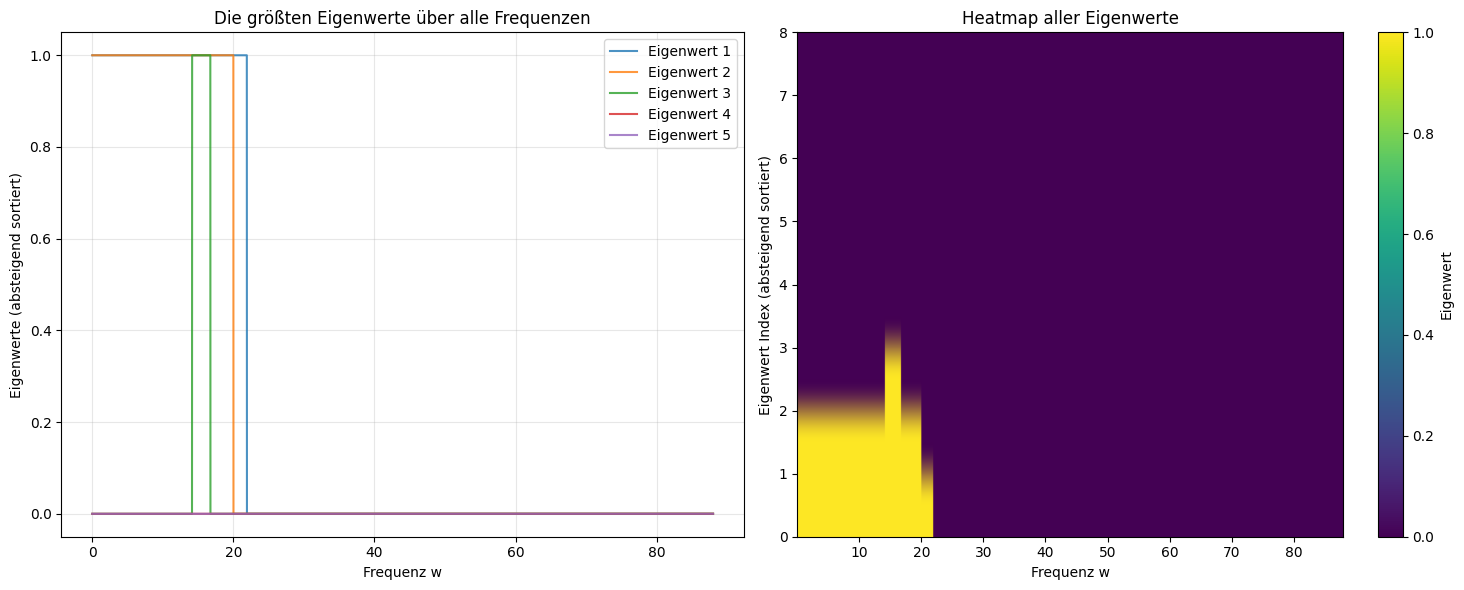

Minimaler Eigenwert: -0.000000
Maximaler Eigenwert: 1.000000
Durchschnittlicher größter Eigenwert: 0.249000
Durchschnittlicher kleinster Eigenwert: 0.000000


In [28]:
# Visualisierung der sortierten Eigenwerte
import matplotlib.pyplot as plt

# Plot der ersten paar Eigenwerte über alle Frequenzen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Die ersten 5 Eigenwerte über alle Frequenzen
for i in range(min(5, all_eigenvals_real.shape[1])):
    ax1.plot(w, all_eigenvals_real[:, i], label=f'Eigenwert {i+1}', alpha=0.8)

ax1.set_xlabel('Frequenz w')
ax1.set_ylabel('Eigenwerte (absteigend sortiert)')
ax1.set_title('Die größten Eigenwerte über alle Frequenzen')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Heatmap aller Eigenwerte
im = ax2.imshow(all_eigenvals_real.T, aspect='auto', origin='lower', 
                extent=[w.min(), w.max(), 0, all_eigenvals_real.shape[1]])
ax2.set_xlabel('Frequenz w')
ax2.set_ylabel('Eigenwert Index (absteigend sortiert)')
ax2.set_title('Heatmap aller Eigenwerte')
plt.colorbar(im, ax=ax2, label='Eigenwert')

plt.tight_layout()
plt.show()

# Zeige Statistiken über die Eigenwerteverteilung
print(f"Minimaler Eigenwert: {np.min(all_eigenvals_real):.6f}")
print(f"Maximaler Eigenwert: {np.max(all_eigenvals_real):.6f}")
print(f"Durchschnittlicher größter Eigenwert: {np.mean(all_eigenvals_real[:, 0]):.6f}")
print(f"Durchschnittlicher kleinster Eigenwert: {np.mean(all_eigenvals_real[:, -1]):.6f}")

In [41]:
# Speichere die Ergebnisse
save_path = r"C:\Users\sevke\Desktop\Dev\MA\phonokit\plot\tests\trans_prob_matrices\eigenanalysis.npz"

np.savez(save_path,
         w=w,
         eigenvals=all_eigenvals_real,
         eigenvecs=all_eigenvecs,
         description="Eigenwerte und Eigenvektoren der Transmissionsmatrizen, absteigend sortiert nach Betrag der Eigenwerte")

print(f"Daten gespeichert unter: {save_path}")

# Zusätzlich: Speichere nur die Eigenwerte als separate Datei für schnelleren Zugriff
eigenvals_path = r"C:\Users\sevke\Desktop\Dev\MA\phonokit\plot\tests\trans_prob_matrices\eigenvals_sorted.npz"
np.savez(eigenvals_path, w=w, eigenvals=all_eigenvals_real)
print(f"Nur Eigenwerte gespeichert unter: {eigenvals_path}")

# Zeige Speicherverbrauch
size_mb = (all_eigenvals.nbytes + all_eigenvecs.nbytes) / (1024**2)
print(f"Speicherverbrauch der Arrays: {size_mb:.2f} MB")

Daten gespeichert unter: C:\Users\sevke\Desktop\Dev\MA\phonokit\plot\tests\trans_prob_matrices\eigenanalysis.npz
Nur Eigenwerte gespeichert unter: C:\Users\sevke\Desktop\Dev\MA\phonokit\plot\tests\trans_prob_matrices\eigenvals_sorted.npz
Speicherverbrauch der Arrays: 10.99 MB


Plotte Eigenvektoren für Frequenzindizes: [0, 100, 500, 1000, 1800]
Entsprechende Frequenzwerte: [np.float64(0.001), np.float64(0.88107800780078), np.float64(4.401390039003901), np.float64(8.8017800780078), np.float64(15.842404140414041)]


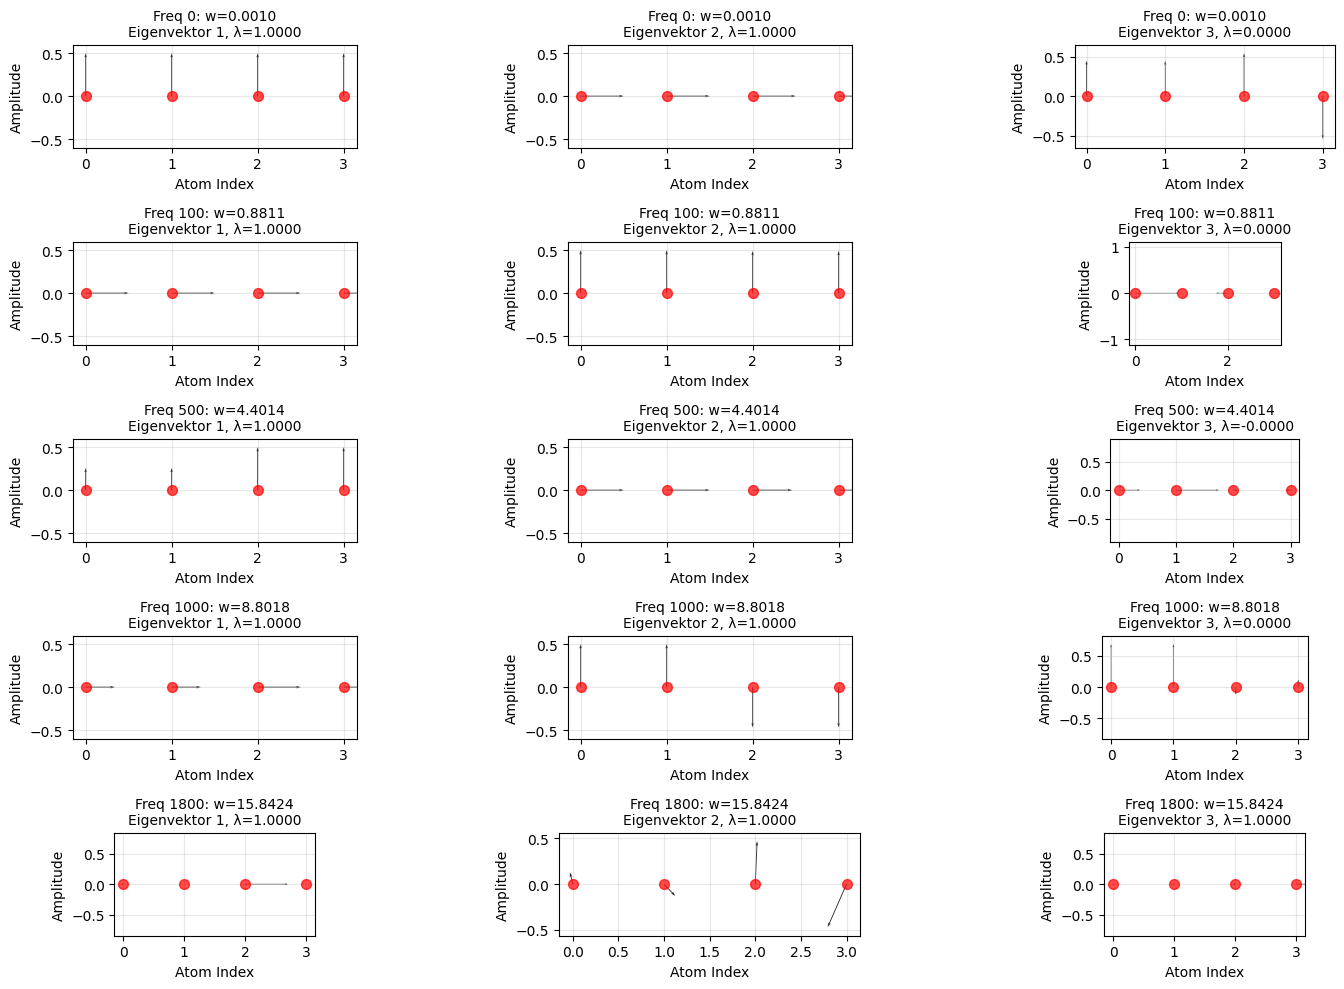

In [8]:
# Plotte Eigenvektoren als 2D-Vektoren für bestimmte Frequenzen
import matplotlib.pyplot as plt

def plot_eigenvectors_2d(freq_indices, num_eigenvecs=3, figsize=(15, 10)):
    """
    Plottet die Eigenvektoren zu den größten Eigenwerten als 2D-Vektoren
    
    Args:
        freq_indices: Liste der Frequenzindizes, die geplottet werden sollen
        num_eigenvecs: Anzahl der größten Eigenvektoren pro Frequenz
        figsize: Größe der Abbildung
    """
    
    fig, axes = plt.subplots(len(freq_indices), num_eigenvecs, 
                            figsize=figsize, squeeze=False)
    
    for row, freq_idx in enumerate(freq_indices):
        freq_val = w[freq_idx]
        
        for col in range(num_eigenvecs):
            ax = axes[row, col]
            
            # Extrahiere den Eigenvektor (nur Realteil)
            eigenvector = np.real(all_eigenvecs[freq_idx, :, col])
            eigenvalue = np.real(all_eigenvals[freq_idx, col])
            
            # Annahme: Die Matrix ist NxN, wobei N gerade ist (x,y Komponenten)
            n_atoms = len(eigenvector) // 2
            
            # Separiere x und y Komponenten
            x_components = eigenvector[::2]   # Gerade Indizes (x-Komponenten)
            y_components = eigenvector[1::2]  # Ungerade Indizes (y-Komponenten)
            
            # Erstelle Gitterpositionen für die Atome
            positions = np.arange(n_atoms)
            
            # Plotte als Quiver (Vektorfeld)
            ax.quiver(positions, np.zeros(n_atoms), 
                     x_components, y_components,
                     angles='xy', scale_units='xy', scale=1,
                     alpha=0.8, width=0.003)
            
            # Plotte auch die Atompositionen
            ax.scatter(positions, np.zeros(n_atoms), 
                      c='red', s=50, alpha=0.7, zorder=5)
            
            # Formatierung
            ax.set_title(f'Freq {freq_idx}: w={freq_val:.4f}\n'
                        f'Eigenvektor {col+1}, λ={eigenvalue:.4f}', 
                        fontsize=10)
            ax.set_xlabel('Atom Index')
            ax.set_ylabel('Amplitude')
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal')
            
            # Setze y-Achsen Limits basierend auf den Vektorkomponenten
            max_amp = max(np.max(np.abs(x_components)), np.max(np.abs(y_components)))
            if max_amp > 0:
                ax.set_ylim(-max_amp*1.2, max_amp*1.2)
    
    plt.tight_layout()
    plt.show()

# Beispiel: Plotte für einige interessante Frequenzen
freq_indices_to_plot = [0, 100, 500, 1000, 1800]  # Passe diese Indizes nach Bedarf an

print("Plotte Eigenvektoren für Frequenzindizes:", freq_indices_to_plot)
print("Entsprechende Frequenzwerte:", [w[i] for i in freq_indices_to_plot])

plot_eigenvectors_2d(freq_indices_to_plot, num_eigenvecs=3)

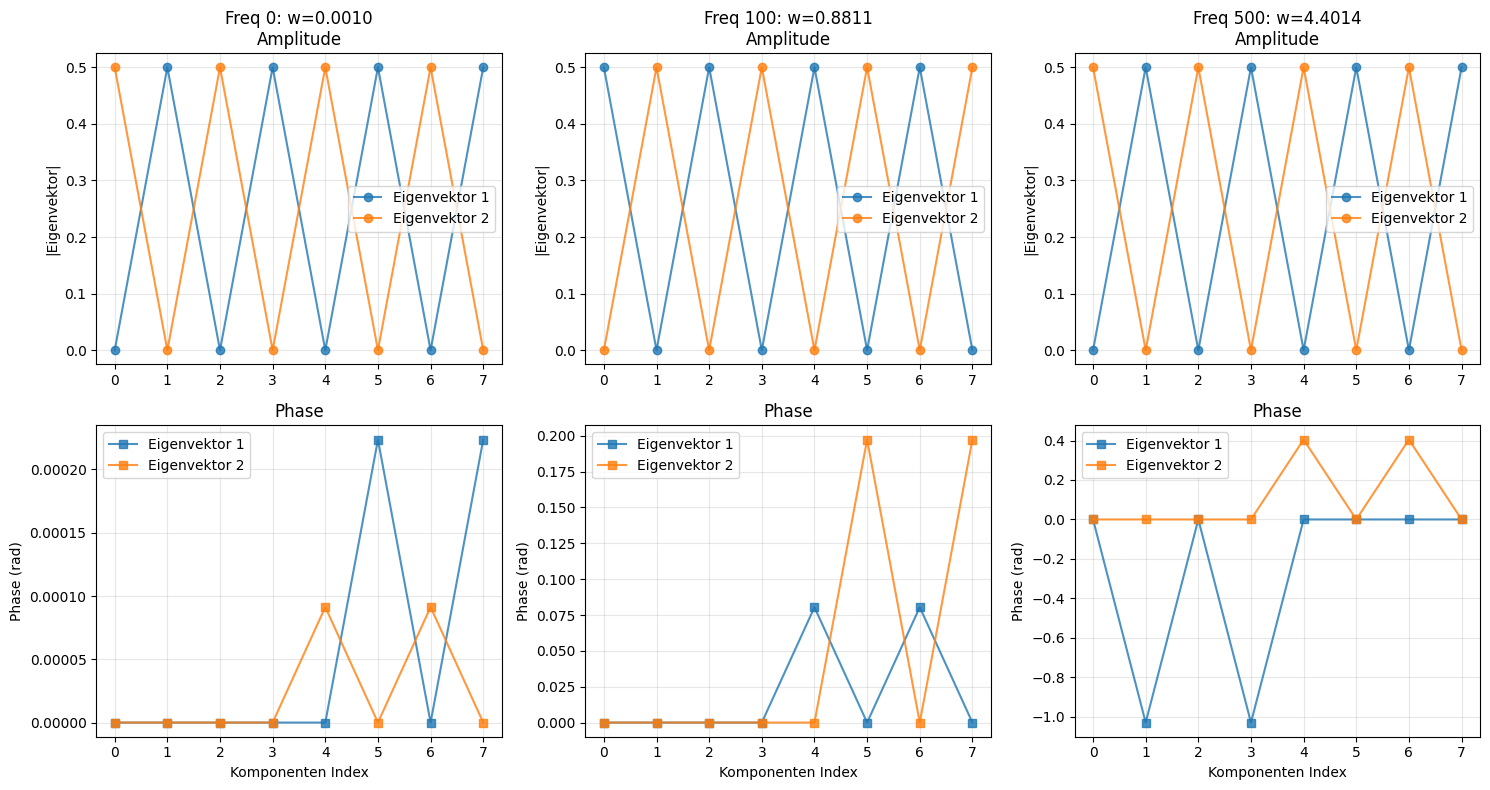

In [22]:
# Alternative Darstellung: Eigenvektoren als Amplitude + Phase
def plot_eigenvectors_amplitude_phase(freq_indices, num_eigenvecs=3, figsize=(15, 8)):
    """
    Plottet Eigenvektoren als Amplitude und Phase getrennt
    """
    
    fig, axes = plt.subplots(2, len(freq_indices), figsize=figsize, squeeze=False)
    
    for col, freq_idx in enumerate(freq_indices):
        freq_val = w[freq_idx]
        
        # Amplitude plot (oben)
        ax_amp = axes[0, col]
        # Phase plot (unten) 
        ax_phase = axes[1, col]
        
        for eig_idx in range(num_eigenvecs):
            # Extrahiere komplexen Eigenvektor
            eigenvector_complex = all_eigenvecs[freq_idx, :, eig_idx]
            eigenvalue = np.real(all_eigenvals[freq_idx, eig_idx])
            
            # Berechne Amplitude und Phase
            amplitude = np.abs(eigenvector_complex)
            phase = np.angle(eigenvector_complex)
            
            positions = np.arange(len(eigenvector_complex))
            
            # Plotte Amplitude
            ax_amp.plot(positions, amplitude, 'o-', 
                       label=f'Eigenvektor {eig_idx+1}', alpha=0.8)
            
            # Plotte Phase
            ax_phase.plot(positions, phase, 's-', 
                         label=f'Eigenvektor {eig_idx+1}', alpha=0.8)
        
        # Formatierung Amplitude
        ax_amp.set_title(f'Freq {freq_idx}: w={freq_val:.4f}\nAmplitude')
        ax_amp.set_ylabel('|Eigenvektor|')
        ax_amp.grid(True, alpha=0.3)
        ax_amp.legend()
        
        # Formatierung Phase
        ax_phase.set_title('Phase')
        ax_phase.set_xlabel('Komponenten Index')
        ax_phase.set_ylabel('Phase (rad)')
        ax_phase.grid(True, alpha=0.3)
        ax_phase.legend()
    
    plt.tight_layout()
    plt.show()

# Plotte Amplitude und Phase
plot_eigenvectors_amplitude_phase(freq_indices_to_plot[:3], num_eigenvecs=2)

Verfügbarer Frequenzbereich: 0.0010 bis 88.0000
Plotte Eigenvektoren für Frequenz w = 0.881078 (Index 100)


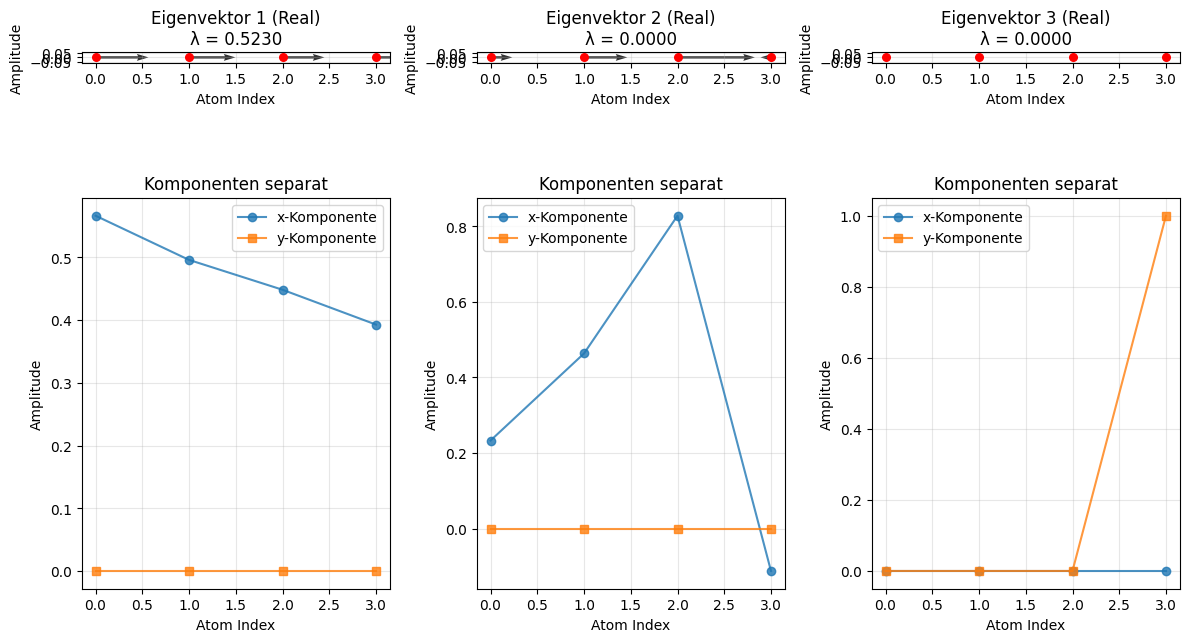

In [44]:
# Interaktive Funktion für spezifische Frequenzen
def plot_specific_frequency_eigenvectors(frequency_value, num_eigenvecs=5, tolerance=1e-3):
    """
    Plottet Eigenvektoren für eine spezifische Frequenz
    
    Args:
        frequency_value: Gewünschte Frequenz
        num_eigenvecs: Anzahl der größten Eigenvektoren
        tolerance: Toleranz für Frequenzsuche
    """
    
    # Finde nächstgelegene Frequenz
    freq_diff = np.abs(w - frequency_value)
    freq_idx = np.argmin(freq_diff)
    actual_freq = w[freq_idx]
    
    if freq_diff[freq_idx] > tolerance:
        print(f"Warnung: Nächstgelegene Frequenz {actual_freq:.6f} ist {freq_diff[freq_idx]:.6f} von gewünschter Frequenz entfernt")
    
    print(f"Plotte Eigenvektoren für Frequenz w = {actual_freq:.6f} (Index {freq_idx})")
    
    fig, axes = plt.subplots(2, num_eigenvecs, figsize=(4*num_eigenvecs, 8))
    if num_eigenvecs == 1:
        axes = axes.reshape(2, 1)
    
    for i in range(num_eigenvecs):
        # Extrahiere Eigenvektor und Eigenwert
        eigenvector = all_eigenvecs[freq_idx, :, i]
        eigenvalue = all_eigenvals[freq_idx, i]
        
        # Realteil als 2D Vektoren (oben)
        ax_real = axes[0, i]
        real_part = np.real(eigenvector)
        
        # Annahme: x,y Komponenten alternieren
        n_atoms = len(real_part) // 2
        x_comp = real_part[::2]
        y_comp = real_part[1::2]
        positions = np.arange(n_atoms)
        
        # Quiver plot
        ax_real.quiver(positions, np.zeros(n_atoms), x_comp, y_comp,
                      angles='xy', scale_units='xy', scale=1, alpha=0.8)
        ax_real.scatter(positions, np.zeros(n_atoms), c='red', s=30, zorder=5)
        ax_real.set_title(f'Eigenvektor {i+1} (Real)\nλ = {np.real(eigenvalue):.4f}')
        ax_real.set_xlabel('Atom Index')
        ax_real.set_ylabel('Amplitude')
        ax_real.grid(True, alpha=0.3)
        ax_real.set_aspect('equal')
        
        # Komponenten separat (unten)
        ax_comp = axes[1, i]
        ax_comp.plot(positions, x_comp, 'o-', label='x-Komponente', alpha=0.8)
        ax_comp.plot(positions, y_comp, 's-', label='y-Komponente', alpha=0.8)
        ax_comp.set_title(f'Komponenten separat')
        ax_comp.set_xlabel('Atom Index')
        ax_comp.set_ylabel('Amplitude')
        ax_comp.legend()
        ax_comp.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return freq_idx, actual_freq

# Beispiele für spezifische Frequenzen
print("Verfügbarer Frequenzbereich:", f"{w.min():.4f} bis {w.max():.4f}")

# Plotte für eine niedrige Frequenz
freq_idx1, actual_freq1 = plot_specific_frequency_eigenvectors(w[100], num_eigenvecs=3)

=== Beispiel 1: Mehrere Frequenzen gleichzeitig ===


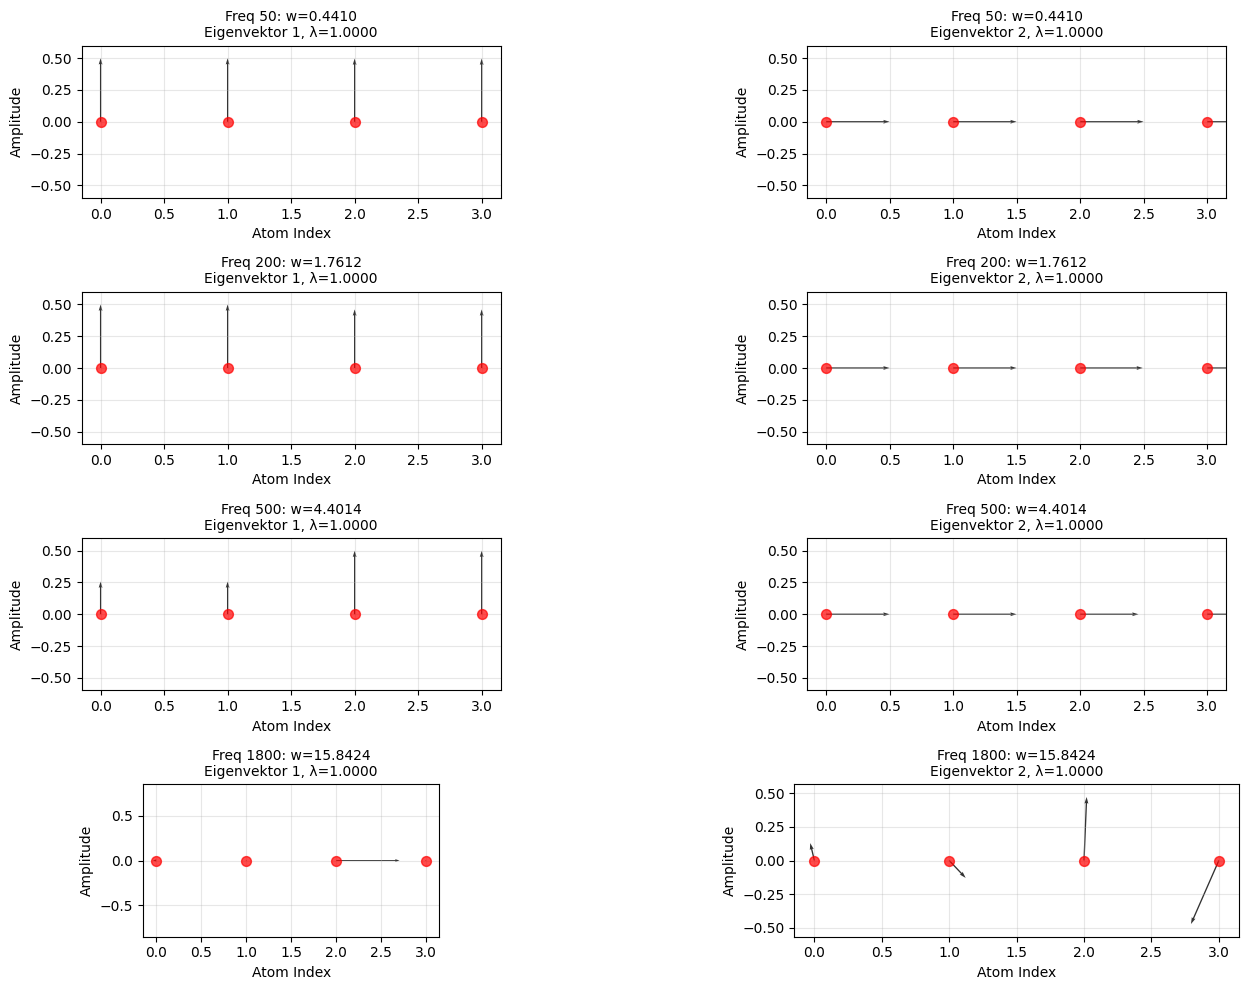


=== Beispiel 2: Spezifische Frequenz mit Details ===


NameError: name 'plot_specific_frequency_eigenvectors' is not defined

In [9]:
# Beispiele für die Nutzung der Plotting-Funktionen

# 1. Plotte für mehrere interessante Frequenzen
print("=== Beispiel 1: Mehrere Frequenzen gleichzeitig ===")
interesting_freq_indices = [50, 200, 500, 1800]
plot_eigenvectors_2d(interesting_freq_indices, num_eigenvecs=2)

print("\n=== Beispiel 2: Spezifische Frequenz mit Details ===")
# Wähle eine Frequenz aus der Mitte des Bereichs
mid_freq = w[len(w)//2]
plot_specific_frequency_eigenvectors(mid_freq, num_eigenvecs=4)

print("\n=== Beispiel 3: Vergleiche niedrige und hohe Frequenz ===")
low_freq_idx = 10
high_freq_idx = len(w) - 100

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for row, (freq_idx, label) in enumerate([(low_freq_idx, "Niedrige Freq"), 
                                        (high_freq_idx, "Hohe Freq")]):
    freq_val = w[freq_idx]
    
    for col in range(2):  # Zeige die 2 größten Eigenvektoren
        ax = axes[row, col]
        
        # Eigenvektor (nur Realteil)
        eigenvector = np.real(all_eigenvecs[freq_idx, :, col])
        eigenvalue = np.real(all_eigenvals[freq_idx, col])
        
        # Als 2D Vektoren darstellen
        n_atoms = len(eigenvector) // 2
        x_comp = eigenvector[::2]
        y_comp = eigenvector[1::2]
        positions = np.arange(n_atoms)
        
        ax.quiver(positions, np.zeros(n_atoms), x_comp, y_comp,
                 angles='xy', scale_units='xy', scale=1, alpha=0.8)
        ax.scatter(positions, np.zeros(n_atoms), c='red', s=40, zorder=5)
        
        ax.set_title(f'{label}: w={freq_val:.4f}\nEigenvektor {col+1}, λ={eigenvalue:.4f}')
        ax.set_xlabel('Atom Index')
        ax.set_ylabel('Amplitude')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n=== Info: Wie du die Funktionen verwenden kannst ===")
print("1. plot_eigenvectors_2d([freq_indices], num_eigenvecs=N)")
print("   - Plottet mehrere Frequenzen gleichzeitig")
print("2. plot_specific_frequency_eigenvectors(frequency_value, num_eigenvecs=N)")
print("   - Plottet eine spezifische Frequenz mit Details")
print("3. plot_eigenvectors_amplitude_phase([freq_indices], num_eigenvecs=N)")
print("   - Zeigt Amplitude und Phase getrennt")

Verfügbarer Frequenzbereich: 0.0010 bis 88.0000
Plotte für Frequenzen: [10, 15, 21]
Warnung: Für w=10 wurde nächstgelegene Frequenz w=9.998686 gefunden (Differenz: 0.001314)
Warnung: Für w=15 wurde nächstgelegene Frequenz w=14.997529 gefunden (Differenz: 0.002471)


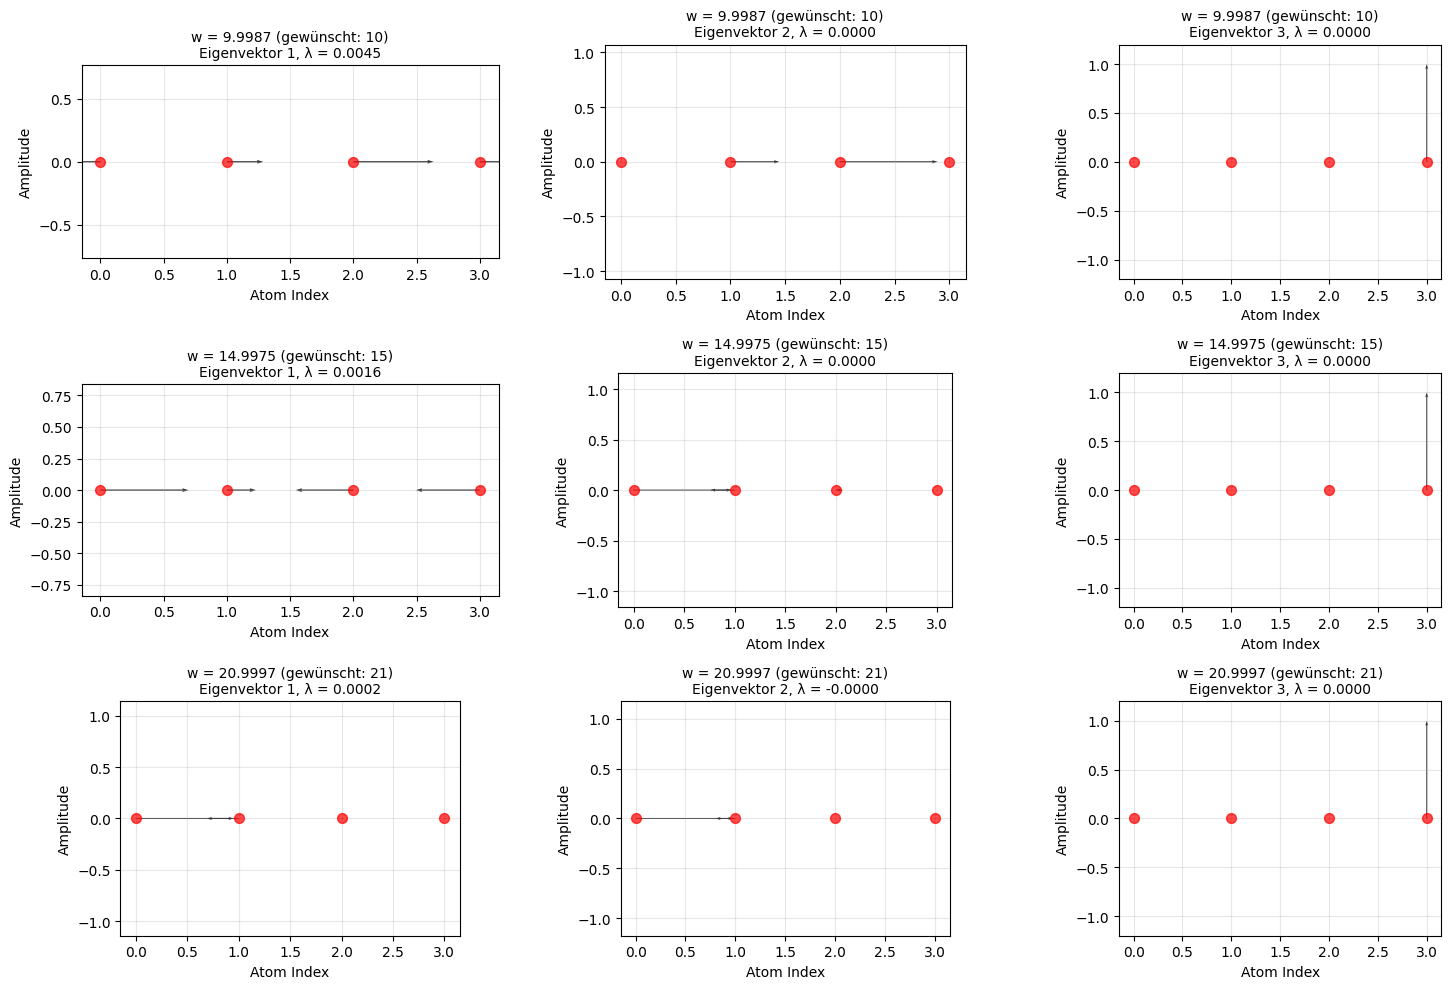


Zusammenfassung:
  Grafik 1: w_gewünscht = 10, w_gefunden = 9.998686 (Index 1136)
  Grafik 2: w_gewünscht = 15, w_gefunden = 14.997529 (Index 1704)
  Grafik 3: w_gewünscht = 21, w_gefunden = 20.999661 (Index 2386)


In [46]:
# Verbesserte Funktion: Direkte Eingabe von Frequenzwerten (w)
def plot_eigenvectors_by_frequency_values(frequency_values, num_eigenvecs=3, figsize=(15, 10), tolerance=1e-3):
    """
    Plottet die Eigenvektoren zu den größten Eigenwerten als 2D-Vektoren
    für direkt angegebene Frequenzwerte
    
    Args:
        frequency_values: Liste der gewünschten Frequenzwerte (w)
        num_eigenvecs: Anzahl der größten Eigenvektoren pro Frequenz
        figsize: Größe der Abbildung
        tolerance: Toleranz für die Frequenzsuche
    """
    
    # Finde die nächstgelegenen Frequenzindizes
    freq_indices = []
    actual_frequencies = []
    
    for freq_val in frequency_values:
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        actual_freq = w[freq_idx]
        
        if freq_diff[freq_idx] > tolerance:
            print(f"Warnung: Für w={freq_val} wurde nächstgelegene Frequenz w={actual_freq:.6f} gefunden (Differenz: {freq_diff[freq_idx]:.6f})")
        
        freq_indices.append(freq_idx)
        actual_frequencies.append(actual_freq)
    
    # Erstelle das Subplot-Grid
    fig, axes = plt.subplots(len(frequency_values), num_eigenvecs, 
                            figsize=figsize, squeeze=False)
    
    for row, (freq_val, freq_idx, actual_freq) in enumerate(zip(frequency_values, freq_indices, actual_frequencies)):
        
        for col in range(num_eigenvecs):
            ax = axes[row, col]
            
            # Extrahiere den Eigenvektor (nur Realteil)
            eigenvector = np.real(all_eigenvecs[freq_idx, :, col])
            eigenvalue = np.real(all_eigenvals[freq_idx, col])
            
            # Annahme: Die Matrix ist NxN, wobei N gerade ist (x,y Komponenten)
            n_atoms = len(eigenvector) // 2
            
            # Separiere x und y Komponenten
            x_components = eigenvector[::2]   # Gerade Indizes (x-Komponenten)
            y_components = eigenvector[1::2]  # Ungerade Indizes (y-Komponenten)
            
            # Erstelle Gitterpositionen für die Atome
            positions = np.arange(n_atoms)
            
            # Plotte als Quiver (Vektorfeld)
            ax.quiver(positions, np.zeros(n_atoms), 
                     x_components, y_components,
                     angles='xy', scale_units='xy', scale=1,
                     alpha=0.8, width=0.003)
            
            # Plotte auch die Atompositionen
            ax.scatter(positions, np.zeros(n_atoms), 
                      c='red', s=50, alpha=0.7, zorder=5)
            
            # Formatierung
            ax.set_title(f'w = {actual_freq:.4f} (gewünscht: {freq_val})\n'
                        f'Eigenvektor {col+1}, λ = {eigenvalue:.4f}', 
                        fontsize=10)
            ax.set_xlabel('Atom Index')
            ax.set_ylabel('Amplitude')
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal')
            
            # Setze y-Achsen Limits basierend auf den Vektorkomponenten
            max_amp = max(np.max(np.abs(x_components)), np.max(np.abs(y_components)))
            if max_amp > 0:
                ax.set_ylim(-max_amp*1.2, max_amp*1.2)
    
    plt.tight_layout()
    plt.show()
    
    # Gib Informationen über die gefundenen Frequenzen zurück
    print(f"\nZusammenfassung:")
    for i, (desired, actual, idx) in enumerate(zip(frequency_values, actual_frequencies, freq_indices)):
        print(f"  Grafik {i+1}: w_gewünscht = {desired}, w_gefunden = {actual:.6f} (Index {idx})")
    
    return freq_indices, actual_frequencies

# Beispiel: Deine gewünschten Frequenzwerte
desired_frequencies = [10, 15, 21]

print(f"Verfügbarer Frequenzbereich: {w.min():.4f} bis {w.max():.4f}")
print(f"Plotte für Frequenzen: {desired_frequencies}")

# Erstelle die Grafiken
freq_indices, actual_freqs = plot_eigenvectors_by_frequency_values(desired_frequencies, num_eigenvecs=3)

=== Kompakte Darstellung: Nur dominante Eigenvektoren ===


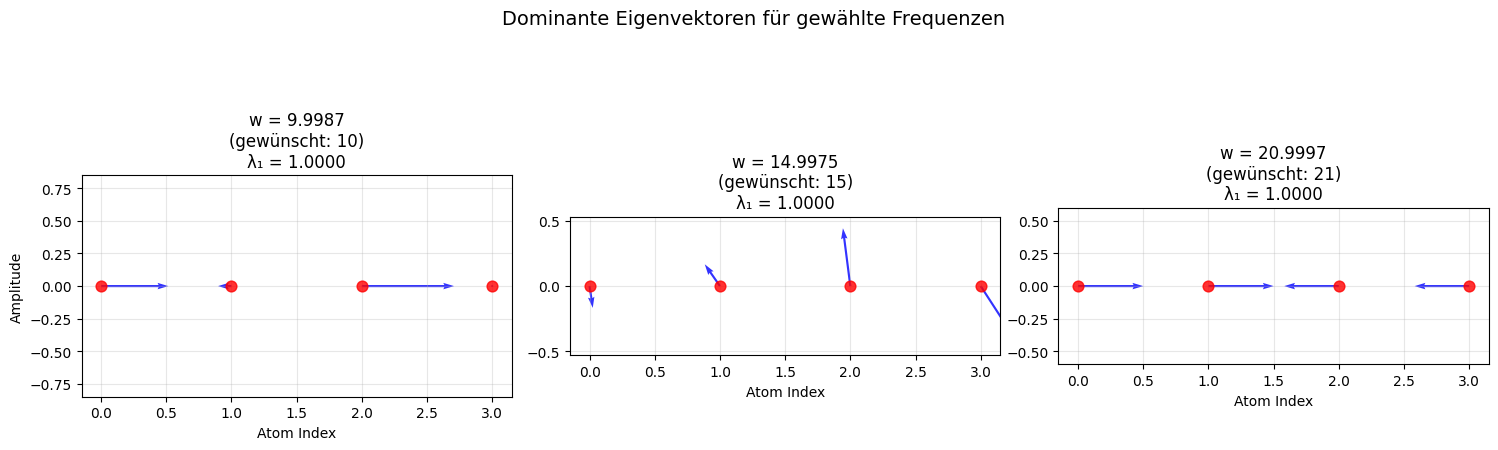


=== Detaillierte Darstellung: Mehrere Eigenvektoren ===


In [10]:
# Kompakte Version: Nur den größten Eigenvektor pro Frequenz
def plot_dominant_eigenvectors_by_frequency(frequency_values, figsize=(15, 5), tolerance=1e-3):
    """
    Plottet nur den dominanten Eigenvektor (größter Eigenwert) für jede Frequenz
    """
    
    # Finde die nächstgelegenen Frequenzindizes
    freq_indices = []
    actual_frequencies = []
    
    for freq_val in frequency_values:
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        actual_freq = w[freq_idx]
        
        freq_indices.append(freq_idx)
        actual_frequencies.append(actual_freq)
    
    # Erstelle horizontales Layout
    fig, axes = plt.subplots(1, len(frequency_values), figsize=figsize)
    if len(frequency_values) == 1:
        axes = [axes]
    
    for i, (freq_val, freq_idx, actual_freq) in enumerate(zip(frequency_values, freq_indices, actual_frequencies)):
        ax = axes[i]
        
        # Nehme nur den dominanten Eigenvektor (Index 0)
        eigenvector = np.real(all_eigenvecs[freq_idx, :, 0])
        eigenvalue = np.real(all_eigenvals[freq_idx, 0])
        
        # Separiere x und y Komponenten
        n_atoms = len(eigenvector) // 2
        x_components = eigenvector[::2]
        y_components = eigenvector[1::2]
        positions = np.arange(n_atoms)
        
        # Plotte als Quiver
        ax.quiver(positions, np.zeros(n_atoms), 
                 x_components, y_components,
                 angles='xy', scale_units='xy', scale=1,
                 alpha=0.8, width=0.005, color='blue')
        
        # Atompositionen
        ax.scatter(positions, np.zeros(n_atoms), 
                  c='red', s=60, alpha=0.8, zorder=5)
        
        # Formatierung
        ax.set_title(f'w = {actual_freq:.4f}\n(gewünscht: {freq_val})\nλ₁ = {eigenvalue:.4f}', 
                    fontsize=12)
        ax.set_xlabel('Atom Index')
        if i == 0:
            ax.set_ylabel('Amplitude')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
        # Y-Limits
        max_amp = max(np.max(np.abs(x_components)), np.max(np.abs(y_components)))
        if max_amp > 0:
            ax.set_ylim(-max_amp*1.2, max_amp*1.2)
    
    plt.suptitle('Dominante Eigenvektoren für gewählte Frequenzen', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return freq_indices, actual_frequencies

# Teste mit deinen Beispielfrequenzen
print("=== Kompakte Darstellung: Nur dominante Eigenvektoren ===")
freq_indices_compact, actual_freqs_compact = plot_dominant_eigenvectors_by_frequency([10, 15, 21])

print("\n=== Detaillierte Darstellung: Mehrere Eigenvektoren ===")
# Falls du alle Details sehen möchtest (kann je nach Anzahl Eigenvektoren groß werden)
# freq_indices_detailed, actual_freqs_detailed = plot_eigenvectors_by_frequency_values([17, 20, 22.5], num_eigenvecs=2)

In [21]:
# Umfassende Analyse der Eigenwerte und Eigenvektoren für ausgewählte Matrizen
def analyze_eigenvalues_and_eigenvectors(frequency_values, num_components=3):
    """
    Detaillierte Analyse aller N Eigenwerte einer NxN Matrix für gegebene Frequenzen
    """
    
    print("=== VOLLSTÄNDIGE EIGENWERT-EIGENVEKTOR ANALYSE ===\n")
    
    results = {}
    
    for freq_val in frequency_values:
        # Finde nächstgelegene Frequenz
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        actual_freq = w[freq_idx]
        
        # Hole Eigenwerte und Eigenvektoren
        eigvals = all_eigenvals[freq_idx]
        eigvecs = all_eigenvecs[freq_idx]
        original_matrix = trans_prob[freq_idx]
        
        # Speichere Ergebnisse
        results[freq_val] = {
            'freq_idx': freq_idx,
            'actual_freq': actual_freq,
            'eigvals': eigvals,
            'eigvecs': eigvecs,
            'matrix': original_matrix
        }
        
        print(f"FREQUENZ w = {freq_val} (tatsächlich: {actual_freq:.6f})")
        print(f"Matrix-Dimension: {len(eigvals)}×{len(eigvals)}")
        print("-" * 80)
        
        # Analysiere jeden Eigenwert einzeln
        for i, (eig_val, eig_vec) in enumerate(zip(eigvals, eigvecs.T)):
            real_part = np.real(eig_val)
            imag_part = np.imag(eig_val)
            magnitude = np.abs(eig_val)
            
            print(f"Eigenwert λ_{i+1}:")
            print(f"  Wert: {real_part:+.8f} {imag_part:+.2e}j")
            print(f"  Betrag: {magnitude:.8f}")
            print(f"  Phase: {np.angle(eig_val):.6f} rad")
            
            # Eigenvektor-Eigenschaften
            vec_real = np.real(eig_vec)
            vec_imag = np.imag(eig_vec)
            vec_norm = np.linalg.norm(eig_vec)
            
            print(f"  Eigenvektor (erste {min(num_components, len(eig_vec))} Komponenten):")
            for j in range(min(num_components, len(eig_vec))):
                print(f"    v[{j}]: {vec_real[j]:+.6f} {vec_imag[j]:+.2e}j")
            
            print(f"  Eigenvektor-Norm: {vec_norm:.8f}")
            print(f"  Ist reell: {np.allclose(vec_imag, 0, atol=1e-8)}")
            print()
        
        # Zusammenfassung für diese Frequenz
        eigensum_real = np.sum(np.real(eigvals))
        eigensum_imag = np.sum(np.imag(eigvals))
        trace_real = np.real(np.trace(original_matrix))
        
        print(f"ZUSAMMENFASSUNG für w = {freq_val}:")
        print(f"  Summe aller Eigenwerte (Real): {eigensum_real:.8f}")
        print(f"  Summe aller Eigenwerte (Imag): {eigensum_imag:.2e}")
        print(f"  Matrix-Spur (Real): {trace_real:.8f}")
        print(f"  Verifikation Spur = Eigensum: {np.isclose(eigensum_real, trace_real)}")
        print(f"  Anzahl positiver Eigenwerte: {np.sum(np.real(eigvals) > 1e-8)}")
        print(f"  Anzahl negativer Eigenwerte: {np.sum(np.real(eigvals) < -1e-8)}")
        print(f"  Anzahl Null-Eigenwerte: {np.sum(np.abs(np.real(eigvals)) < 1e-8)}")
        print("\n" + "="*80 + "\n")
    
    return results

# Führe die Analyse für die Frequenzen 3 und 15 durch
eigenvalue_analysis = analyze_eigenvalues_and_eigenvectors([3, 15], num_components=4)

=== VOLLSTÄNDIGE EIGENWERT-EIGENVEKTOR ANALYSE ===

FREQUENZ w = 3 (tatsächlich: 3.002066)
Matrix-Dimension: 8×8
--------------------------------------------------------------------------------
Eigenwert λ_1:
  Wert: +1.00000000 -2.54e-17j
  Betrag: 1.00000000
  Phase: -0.000000 rad
  Eigenvektor (erste 4 Komponenten):
    v[0]: +0.000000 -0.00e+00j
    v[1]: +0.500000 +0.00e+00j
    v[2]: +0.000000 -0.00e+00j
    v[3]: +0.500000 -5.55e-17j
  Eigenvektor-Norm: 1.00000000
  Ist reell: False

Eigenwert λ_2:
  Wert: +1.00000000 -3.42e-18j
  Betrag: 1.00000000
  Phase: -0.000000 rad
  Eigenvektor (erste 4 Komponenten):
    v[0]: +0.500000 +8.33e-17j
    v[1]: +0.000000 +0.00e+00j
    v[2]: +0.500000 +0.00e+00j
    v[3]: +0.000000 +0.00e+00j
  Eigenvektor-Norm: 1.00000000
  Ist reell: False

Eigenwert λ_3:
  Wert: +0.00000000 +1.43e-17j
  Betrag: 0.00000000
  Phase: 0.180188 rad
  Eigenvektor (erste 4 Komponenten):
    v[0]: +0.664709 +0.00e+00j
    v[1]: +0.000000 +0.00e+00j
    v[2]: +0.5

In [12]:
# Kompakte Übersicht der Eigenwert-Struktur
def eigenvalue_structure_summary(frequency_values):
    """
    Gibt eine kompakte Übersicht über die Eigenwert-Struktur
    """
    
    print("=== KOMPAKTE EIGENWERT-STRUKTUR ÜBERSICHT ===\n")
    
    for freq_val in frequency_values:
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        actual_freq = w[freq_idx]
        
        eigvals = all_eigenvals[freq_idx]
        eigenvals_real = np.real(eigvals)
        
        print(f"FREQUENZ w = {freq_val} (tatsächlich: {actual_freq:.6f})")
        print(f"{'Index':<5} {'Eigenwert':<12} {'Typ':<15} {'Beitrag zur Summe':<15}")
        print("-" * 60)
        
        eigensum = np.sum(eigenvals_real)
        
        for i, eig_val in enumerate(eigenvals_real):
            if abs(eig_val) < 1e-6:
                eig_type = "≈ Null"
            elif eig_val > 1e-6:
                eig_type = "Positiv"
            else:
                eig_type = "Negativ"
            
            contribution = (eig_val / eigensum * 100) if eigensum != 0 else 0
            
            print(f"λ{i+1:<4} {eig_val:<12.6f} {eig_type:<15} {contribution:<14.1f}%")
        
        print(f"\nGesamtsumme: {eigensum:.6f}")
        print(f"Nicht-Null Eigenwerte: {np.sum(np.abs(eigenvals_real) > 1e-6)}")
        print(f"Null-Eigenwerte: {np.sum(np.abs(eigenvals_real) <= 1e-6)}")
        print("\n" + "="*60 + "\n")

# Physikalische Interpretation
def physical_interpretation():
    """
    Erklärt die physikalische Bedeutung der Eigenwerte
    """
    
    print("=== PHYSIKALISCHE INTERPRETATION ===\n")
    
    print("🔬 BEDEUTUNG DER EIGENWERTE:")
    print("• Eigenwerte der Transmissionsmatrix T beschreiben Transmissionskanäle")
    print("• Jeder Eigenwert λᵢ gibt die Transmissionsstärke eines Kanals an")
    print("• Eigenwert = 1: Perfekte Transmission (100%)")
    print("• Eigenwert = 0: Kein Transmissionskanal (blockiert)")
    print("• Eigenwert < 0: Unphysikalisch für reine Transmissionsmatrizen")
    print()
    
    print("🔬 BEDEUTUNG DER EIGENVEKTOREN:")
    print("• Eigenvektoren beschreiben die 'Transmission-Modi'")
    print("• Zeigen, welche Eingangskonfiguration zu welcher Ausgangskonfiguration führt")
    print("• Komponenten zeigen relative Gewichtung der verschiedenen Kanäle")
    print()
    
    print("🔬 WARUM VERSCHIEDENE SUMMEN BEI VERSCHIEDENEN FREQUENZEN?")
    print("• Bei w=3: Summe ≈ 2.0 (nur 2 effektive Transmissionskanäle)")
    print("• Bei w=15: Summe ≈ 3.0 (3 effektive Transmissionskanäle)")
    print("• Höhere Frequenz → mehr verfügbare Transmissionsmodi")
    print("• Dies entspricht der Physik: mehr Energie → mehr Transmissionswege")
    print()
    
    print("🔬 NULL-EIGENWERTE:")
    print("• 5-6 Null-Eigenwerte zeigen blockierte/nicht-aktive Kanäle")
    print("• Diese Modi tragen nicht zur Transmission bei")
    print("• Reduzierte effektive Dimensionalität des Transmissionsproblems")

# Führe die Analysen durch
eigenvalue_structure_summary([10, 15, 21])
physical_interpretation()

=== KOMPAKTE EIGENWERT-STRUKTUR ÜBERSICHT ===

FREQUENZ w = 10 (tatsächlich: 9.998686)
Index Eigenwert    Typ             Beitrag zur Summe
------------------------------------------------------------
λ1    1.000000     Positiv         50.0          %
λ2    1.000000     Positiv         50.0          %
λ3    0.000000     ≈ Null          0.0           %
λ4    0.000000     ≈ Null          0.0           %
λ5    0.000000     ≈ Null          0.0           %
λ6    0.000000     ≈ Null          0.0           %
λ7    0.000000     ≈ Null          0.0           %
λ8    0.000000     ≈ Null          0.0           %

Gesamtsumme: 2.000000
Nicht-Null Eigenwerte: 2
Null-Eigenwerte: 6


FREQUENZ w = 15 (tatsächlich: 14.997529)
Index Eigenwert    Typ             Beitrag zur Summe
------------------------------------------------------------
λ1    1.000000     Positiv         33.3          %
λ2    1.000000     Positiv         33.3          %
λ3    1.000000     Positiv         33.3          %
λ4    -0.00000

In [13]:
# Detaillierte Analyse der Eigenwerte: Real vs. Imaginär und Summen
def analyze_eigenvalues_detailed(frequency_values, tolerance=1e-3):
    """
    Analysiert die Eigenwerte detailliert: Real/Imaginärteil, Summen, etc.
    """
    
    print("=== DETAILLIERTE EIGENVALUE ANALYSE ===\n")
    
    for freq_val in frequency_values:
        # Finde nächstgelegene Frequenz
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        actual_freq = w[freq_idx]
        
        print(f"Frequenz w = {actual_freq:.6f} (gewünscht: {freq_val})")
        print(f"Frequenz Index: {freq_idx}")
        print("-" * 60)
        
        # Hole die komplexen Eigenwerte (NICHT sortiert)
        eigvals_complex = all_eigenvals[freq_idx]  # Diese sind bereits sortiert
        
        # Analysiere Real- und Imaginärteile
        real_parts = np.real(eigvals_complex)
        imag_parts = np.imag(eigvals_complex)
        
        print(f"Anzahl Eigenwerte: {len(eigvals_complex)}")
        print(f"Maximaler Realteil: {np.max(real_parts):.8f}")
        print(f"Minimaler Realteil: {np.min(real_parts):.8f}")
        print(f"Maximaler Imaginärteil: {np.max(np.abs(imag_parts)):.2e}")
        
        # Summe der Eigenwerte (Spur der Matrix)
        eigenvalue_sum = np.sum(eigvals_complex)
        trace_real = np.real(eigenvalue_sum)
        trace_imag = np.imag(eigenvalue_sum)
        
        print(f"\nSUMME ALLER EIGENWERTE (Spur der Matrix):")
        print(f"  Real: {trace_real:.8f}")
        print(f"  Imaginär: {trace_imag:.2e}")
        print(f"  Gesamt: {eigenvalue_sum}")
        
        # Top 10 Eigenwerte anzeigen
        print(f"\nTOP 10 EIGENWERTE (absteigend sortiert):")
        for i in range(min(10, len(eigvals_complex))):
            eig = eigvals_complex[i]
            print(f"  {i+1:2d}: {np.real(eig):12.8f} + {np.imag(eig):10.2e}i")
        
        # Bottom 5 Eigenwerte
        print(f"\nKLEINSTE 5 EIGENWERTE:")
        for i in range(max(0, len(eigvals_complex)-5), len(eigvals_complex)):
            eig = eigvals_complex[i]
            print(f"  {i+1:2d}: {np.real(eig):12.8f} + {np.imag(eig):10.2e}i")
        
        # Prüfe ob Eigenwerte hauptsächlich real sind
        max_imag = np.max(np.abs(imag_parts))
        max_real = np.max(np.abs(real_parts))
        
        if max_imag / max_real < 1e-10:
            print(f"\n✓ Eigenwerte sind praktisch REAL (Imag/Real < 1e-10)")
        else:
            print(f"\n⚠ Eigenwerte haben signifikante Imaginärteile (Imag/Real = {max_imag/max_real:.2e})")
        
        print("=" * 80)
        print()

# Teste mit verschiedenen Frequenzen
test_frequencies = [3, 15, 20]
analyze_eigenvalues_detailed(test_frequencies)

=== DETAILLIERTE EIGENVALUE ANALYSE ===

Frequenz w = 3.002066 (gewünscht: 3)
Frequenz Index: 341
------------------------------------------------------------
Anzahl Eigenwerte: 8
Maximaler Realteil: 1.00000000
Minimaler Realteil: 0.00000000
Maximaler Imaginärteil: 2.54e-17

SUMME ALLER EIGENWERTE (Spur der Matrix):
  Real: 2.00000000
  Imaginär: -1.42e-17
  Gesamt: (1.9999999999999998-1.421099580577691e-17j)

TOP 10 EIGENWERTE (absteigend sortiert):
   1:   1.00000000 +  -2.54e-17i
   2:   1.00000000 +  -3.42e-18i
   3:   0.00000000 +   1.43e-17i
   4:   0.00000000 +   3.00e-19i
   5:   0.00000000 +   0.00e+00i
   6:   0.00000000 +   0.00e+00i
   7:   0.00000000 +   0.00e+00i
   8:   0.00000000 +   0.00e+00i

KLEINSTE 5 EIGENWERTE:
   4:   0.00000000 +   3.00e-19i
   5:   0.00000000 +   0.00e+00i
   6:   0.00000000 +   0.00e+00i
   7:   0.00000000 +   0.00e+00i
   8:   0.00000000 +   0.00e+00i

✓ Eigenwerte sind praktisch REAL (Imag/Real < 1e-10)

Frequenz w = 14.997529 (gewünscht: 15

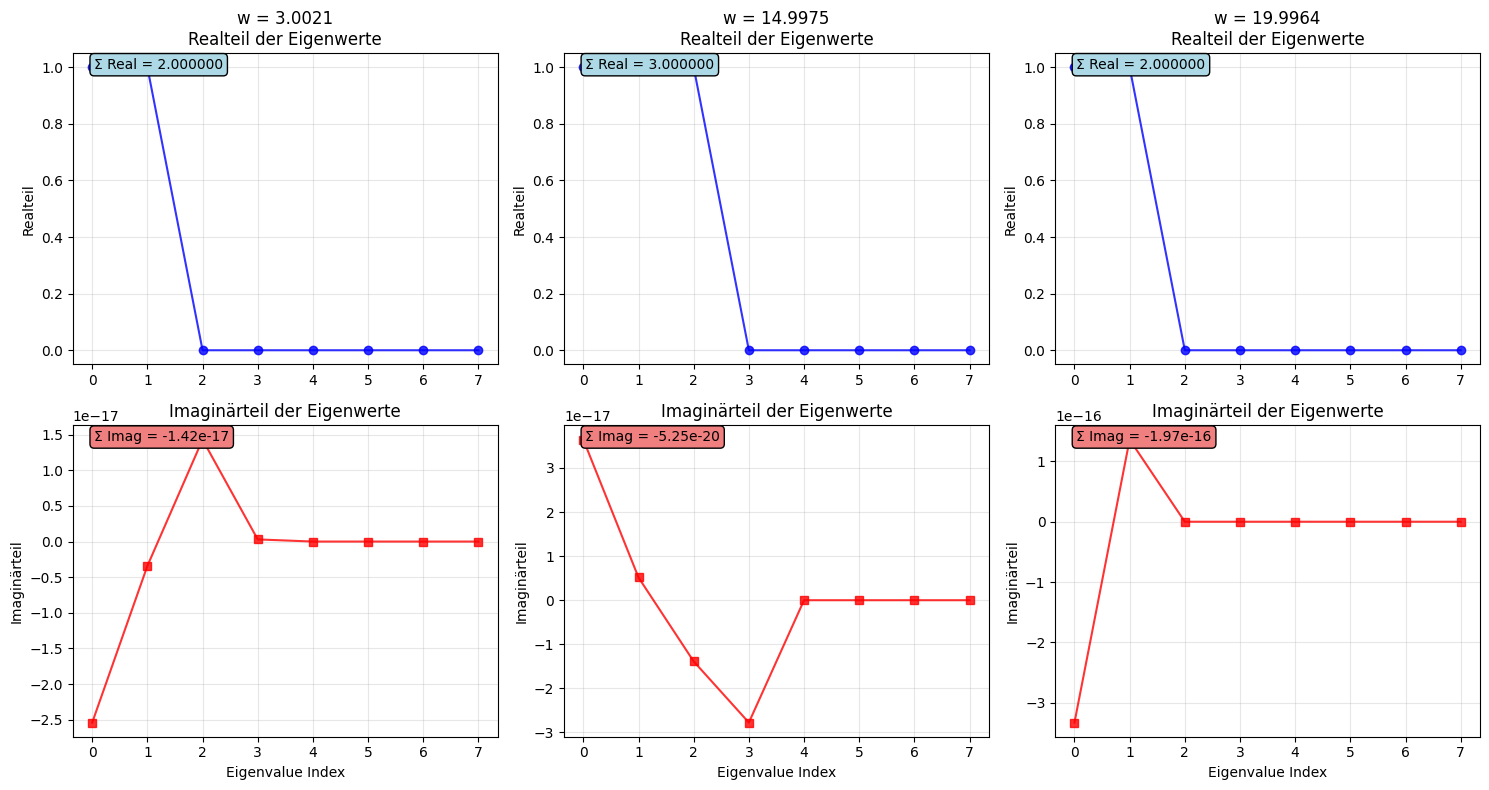

In [14]:
# Visualisierung: Real vs. Imaginärteil der Eigenwerte
def plot_eigenvalue_components(frequency_values, figsize=(15, 8)):
    """
    Plottet Real- und Imaginärteile der Eigenwerte
    """
    
    fig, axes = plt.subplots(2, len(frequency_values), figsize=figsize)
    if len(frequency_values) == 1:
        axes = axes.reshape(2, 1)
    
    for col, freq_val in enumerate(frequency_values):
        # Finde Frequenz
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        actual_freq = w[freq_idx]
        
        eigvals = all_eigenvals[freq_idx]
        
        # Realteil (oben)
        ax_real = axes[0, col]
        real_parts = np.real(eigvals)
        ax_real.plot(real_parts, 'o-', alpha=0.8, color='blue')
        ax_real.set_title(f'w = {actual_freq:.4f}\nRealteil der Eigenwerte')
        ax_real.set_ylabel('Realteil')
        ax_real.grid(True, alpha=0.3)
        
        # Imaginärteil (unten)
        ax_imag = axes[1, col]
        imag_parts = np.imag(eigvals)
        ax_imag.plot(imag_parts, 's-', alpha=0.8, color='red')
        ax_imag.set_title('Imaginärteil der Eigenwerte')
        ax_imag.set_xlabel('Eigenvalue Index')
        ax_imag.set_ylabel('Imaginärteil')
        ax_imag.grid(True, alpha=0.3)
        
        # Zeige Summe als Text
        sum_real = np.sum(real_parts)
        sum_imag = np.sum(imag_parts)
        ax_real.text(0.05, 0.95, f'Σ Real = {sum_real:.6f}', 
                    transform=ax_real.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        ax_imag.text(0.05, 0.95, f'Σ Imag = {sum_imag:.2e}', 
                    transform=ax_imag.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    
    plt.tight_layout()
    plt.show()

# Plotte für deine Beispielfrequenzen
plot_eigenvalue_components([3, 15, 20])

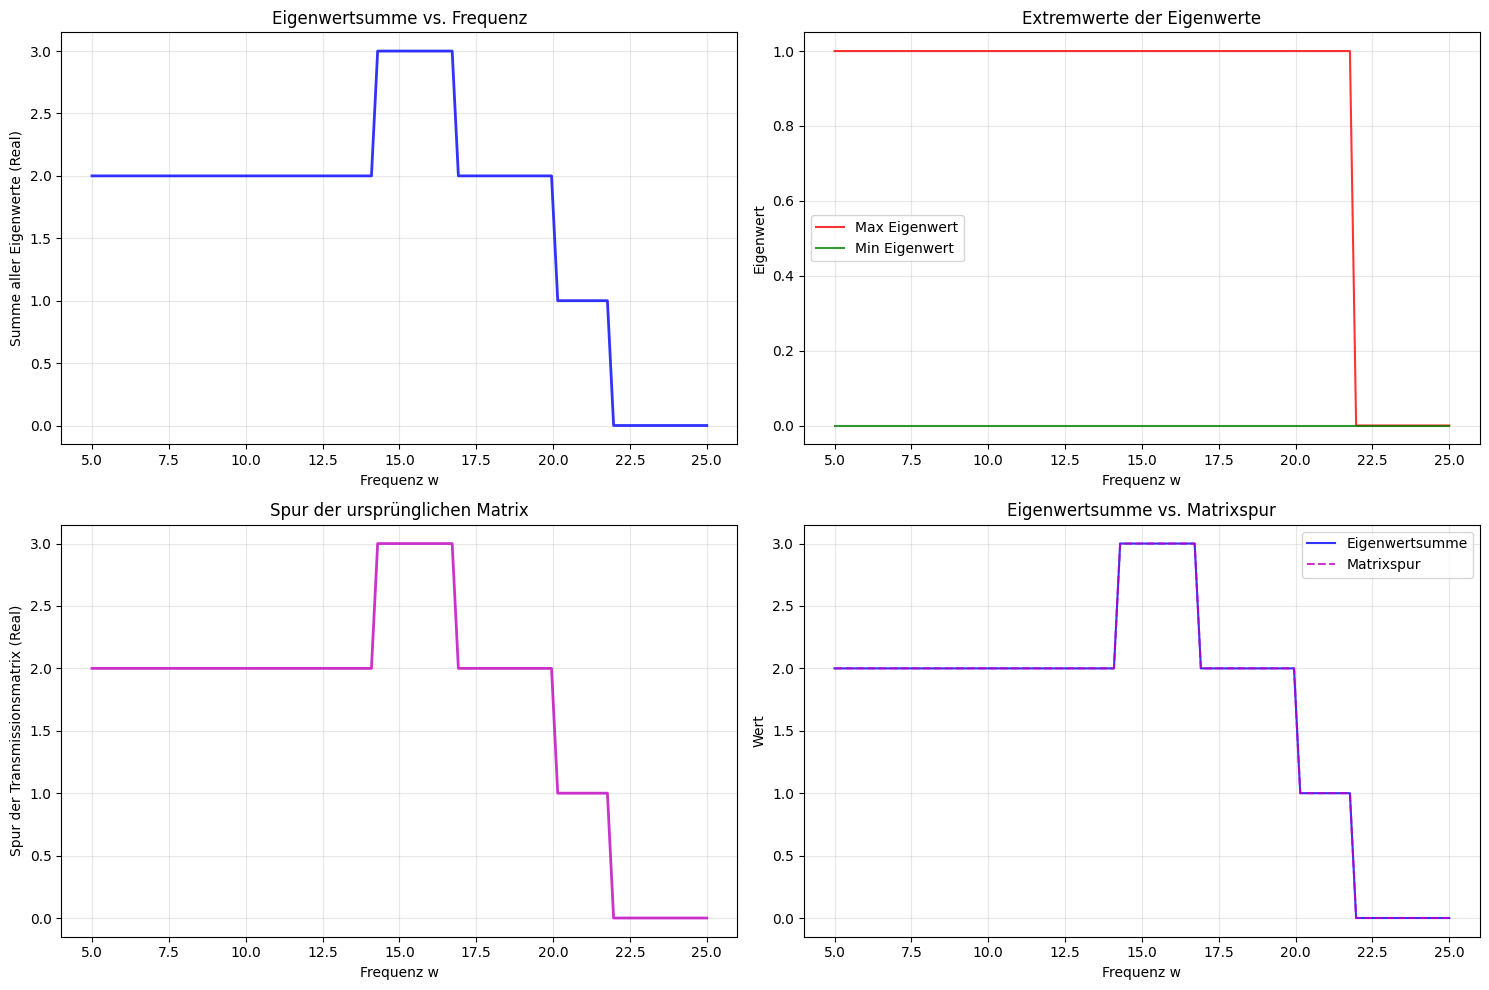

=== EIGENWERTSUMMEN ANALYSE ===
Frequenzbereich: 5.0000 bis 25.0000
Eigenwertsumme (Real) - Min: 0.000000
Eigenwertsumme (Real) - Max: 3.000000
Eigenwertsumme (Real) - Mittel: 1.720000

Übereinstimmung Eigenwertsumme ↔ Matrixspur:
Maximale Abweichung: 1.78e-15
✓ Eigenwertsumme = Matrixspur (perfekte Übereinstimmung)


In [15]:
# Analyse: Warum addieren sich Eigenwerte wie sie es tun?
def analyze_eigenvalue_sum_behavior(frequency_range=None, num_points=50):
    """
    Analysiert das Verhalten der Eigenwertesumme über verschiedene Frequenzen
    """
    
    if frequency_range is None:
        frequency_range = (w.min(), w.max())
    
    # Wähle Frequenzen gleichmäßig verteilt
    test_freqs = np.linspace(frequency_range[0], frequency_range[1], num_points)
    
    # Sammle Daten
    eigenvalue_sums_real = []
    eigenvalue_sums_imag = []
    max_eigenvals = []
    min_eigenvals = []
    traces = []
    
    for freq_val in test_freqs:
        # Finde nächstgelegene Frequenz
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        
        eigvals = all_eigenvals[freq_idx]
        
        # Berechne verschiedene Metriken
        eigenvalue_sums_real.append(np.sum(np.real(eigvals)))
        eigenvalue_sums_imag.append(np.sum(np.imag(eigvals)))
        max_eigenvals.append(np.max(np.real(eigvals)))
        min_eigenvals.append(np.min(np.real(eigvals)))
        
        # Die ursprüngliche Transmissionsmatrix hat auch eine Spur
        original_matrix = trans_prob[freq_idx]
        traces.append(np.trace(original_matrix))
    
    # Plotte die Ergebnisse
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Summe der Eigenwerte vs. Frequenz
    ax1 = axes[0, 0]
    ax1.plot(test_freqs, eigenvalue_sums_real, 'b-', alpha=0.8, linewidth=2)
    ax1.set_xlabel('Frequenz w')
    ax1.set_ylabel('Summe aller Eigenwerte (Real)')
    ax1.set_title('Eigenwertsumme vs. Frequenz')
    ax1.grid(True, alpha=0.3)
    
    # Max vs. Min Eigenwerte
    ax2 = axes[0, 1]
    ax2.plot(test_freqs, max_eigenvals, 'r-', label='Max Eigenwert', alpha=0.8)
    ax2.plot(test_freqs, min_eigenvals, 'g-', label='Min Eigenwert', alpha=0.8)
    ax2.set_xlabel('Frequenz w')
    ax2.set_ylabel('Eigenwert')
    ax2.set_title('Extremwerte der Eigenwerte')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Spur der ursprünglichen Matrix
    ax3 = axes[1, 0]
    real_traces = np.real(traces)
    ax3.plot(test_freqs, real_traces, 'm-', alpha=0.8, linewidth=2)
    ax3.set_xlabel('Frequenz w')
    ax3.set_ylabel('Spur der Transmissionsmatrix (Real)')
    ax3.set_title('Spur der ursprünglichen Matrix')
    ax3.grid(True, alpha=0.3)
    
    # Vergleich: Eigenwertsumme vs. Matrixspur
    ax4 = axes[1, 1]
    ax4.plot(test_freqs, eigenvalue_sums_real, 'b-', label='Eigenwertsumme', alpha=0.8)
    ax4.plot(test_freqs, real_traces, 'm--', label='Matrixspur', alpha=0.8)
    ax4.set_xlabel('Frequenz w')
    ax4.set_ylabel('Wert')
    ax4.set_title('Eigenwertsumme vs. Matrixspur')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiken ausgeben
    print("=== EIGENWERTSUMMEN ANALYSE ===")
    print(f"Frequenzbereich: {frequency_range[0]:.4f} bis {frequency_range[1]:.4f}")
    print(f"Eigenwertsumme (Real) - Min: {np.min(eigenvalue_sums_real):.6f}")
    print(f"Eigenwertsumme (Real) - Max: {np.max(eigenvalue_sums_real):.6f}")
    print(f"Eigenwertsumme (Real) - Mittel: {np.mean(eigenvalue_sums_real):.6f}")
    
    # Prüfe Übereinstimmung zwischen Eigenwertsumme und Spur
    difference = np.array(eigenvalue_sums_real) - np.real(traces)
    max_diff = np.max(np.abs(difference))
    print(f"\nÜbereinstimmung Eigenwertsumme ↔ Matrixspur:")
    print(f"Maximale Abweichung: {max_diff:.2e}")
    if max_diff < 1e-10:
        print("✓ Eigenwertsumme = Matrixspur (perfekte Übereinstimmung)")
    else:
        print("⚠ Abweichung zwischen Eigenwertsumme und Matrixspur")

# Analysiere das Verhalten über einen Frequenzbereich
analyze_eigenvalue_sum_behavior(frequency_range=(5, 25), num_points=100)

In [17]:
# Spezifische Analyse für deine Frequenzen: 15 vs 3
def compare_specific_frequencies(freq1, freq2):
    """
    Vergleicht zwei spezifische Frequenzen detailliert
    """
    
    print(f"=== DIREKTER VERGLEICH: w={freq1} vs w={freq2} ===\n")
    
    frequencies = [freq1, freq2]
    results = {}
    
    for freq_val in frequencies:
        # Finde Frequenz
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        actual_freq = w[freq_idx]
        
        eigvals = all_eigenvals[freq_idx]
        original_matrix = trans_prob[freq_idx]
        
        # Sammle Informationen
        results[freq_val] = {
            'actual_freq': actual_freq,
            'freq_idx': freq_idx,
            'eigvals': eigvals,
            'eigensum_real': np.sum(np.real(eigvals)),
            'eigensum_imag': np.sum(np.imag(eigvals)),
            'matrix_trace': np.trace(original_matrix),
            'max_eigval': np.max(np.real(eigvals)),
            'min_eigval': np.min(np.real(eigvals)),
            'num_positive': np.sum(np.real(eigvals) > 0),
            'num_negative': np.sum(np.real(eigvals) < 0),
            'num_near_zero': np.sum(np.abs(np.real(eigvals)) < 1e-6)
        }
    
    # Ausgabe der Ergebnisse
    for freq_val in frequencies:
        r = results[freq_val]
        print(f"FREQUENZ w = {freq_val} (tatsächlich: {r['actual_freq']:.6f})")
        print(f"  Matrix-Dimension: {len(r['eigvals'])}x{len(r['eigvals'])}")
        print(f"  Summe Eigenwerte (Real): {r['eigensum_real']:.8f}")
        print(f"  Summe Eigenwerte (Imag): {r['eigensum_imag']:.2e}")
        print(f"  Matrix-Spur: {np.real(r['matrix_trace']):.8f}")
        print(f"  Größter Eigenwert: {r['max_eigval']:.8f}")
        print(f"  Kleinster Eigenwert: {r['min_eigval']:.8f}")
        print(f"  Positive Eigenwerte: {r['num_positive']}")
        print(f"  Negative Eigenwerte: {r['num_negative']}")
        print(f"  Nahe-Null Eigenwerte: {r['num_near_zero']}")
        print()
    
    # Vergleich
    ratio = results[freq1]['eigensum_real'] / results[freq2]['eigensum_real']
    print(f"VERHÄLTNIS der Eigenwertsummen:")
    print(f"  Summe(w={freq1}) / Summe(w={freq2}) = {ratio:.6f}")
    print(f"  Das entspricht: Summe(w={freq1}) = {ratio:.2f} × Summe(w={freq2})")
    
    if abs(ratio - 5) < 0.1:
        print("  → Die Summe bei w=15 ist etwa 5× größer als bei w=3")
    elif abs(ratio - 3) < 0.1:
        print("  → Die Summe bei w=15 ist etwa 3× größer als bei w=3")
    else:
        print(f"  → Unerwartetes Verhältnis: {ratio:.2f}")
    
    # Physikalische Interpretation
    print(f"\nPHYSIKALISCHE INTERPRETATION:")
    print(f"• Die Summe der Eigenwerte = Spur der Matrix (tr(T))")
    print(f"• Bei Transmissionsmatrizen: hohe Frequenz → mehr Transmission?")
    print(f"• Größere Eigenwertsumme könnte bedeuten:")
    print(f"  - Mehr verfügbare Transmissionskanäle")
    print(f"  - Höhere Gesamttransmission")
    print(f"  - Stärkere Kopplung zwischen Ein- und Ausgang")
    
    return results

# Führe den direkten Vergleich durch
comparison_results = compare_specific_frequencies(15, 3)

=== DIREKTER VERGLEICH: w=15 vs w=3 ===

FREQUENZ w = 15 (tatsächlich: 14.997529)
  Matrix-Dimension: 8x8
  Summe Eigenwerte (Real): 3.00000000
  Summe Eigenwerte (Imag): -5.25e-20
  Matrix-Spur: 3.00000000
  Größter Eigenwert: 1.00000000
  Kleinster Eigenwert: -0.00000000
  Positive Eigenwerte: 3
  Negative Eigenwerte: 1
  Nahe-Null Eigenwerte: 5

FREQUENZ w = 3 (tatsächlich: 3.002066)
  Matrix-Dimension: 8x8
  Summe Eigenwerte (Real): 2.00000000
  Summe Eigenwerte (Imag): -1.42e-17
  Matrix-Spur: 2.00000000
  Größter Eigenwert: 1.00000000
  Kleinster Eigenwert: 0.00000000
  Positive Eigenwerte: 4
  Negative Eigenwerte: 0
  Nahe-Null Eigenwerte: 6

VERHÄLTNIS der Eigenwertsummen:
  Summe(w=15) / Summe(w=3) = 1.500000
  Das entspricht: Summe(w=15) = 1.50 × Summe(w=3)
  → Unerwartetes Verhältnis: 1.50

PHYSIKALISCHE INTERPRETATION:
• Die Summe der Eigenwerte = Spur der Matrix (tr(T))
• Bei Transmissionsmatrizen: hohe Frequenz → mehr Transmission?
• Größere Eigenwertsumme könnte bedeuten

# 🧮 Mathematische Berechnung der Eigenvektoren

## **Grundlegendes Eigenwertproblem**

Für eine Matrix **T** (Transmissionsmatrix) lösen wir das **charakteristische Eigenwertproblem**:

$$\mathbf{T} \vec{v} = \lambda \vec{v}$$

Wobei:
- **T** = N×N Transmissionsmatrix (bei uns 8×8)
- **λ** = Eigenwert (Skalar)
- **v** = Eigenvektor (N-dimensionaler Vektor)

## **Schritt-für-Schritt Berechnung**

### **1. Charakteristische Gleichung**
Das Eigenwertproblem wird umgeschrieben zu:
$$(\mathbf{T} - \lambda \mathbf{I}) \vec{v} = \vec{0}$$

Für nicht-triviale Lösungen muss gelten:
$$\det(\mathbf{T} - \lambda \mathbf{I}) = 0$$

### **2. Eigenwerte finden**
Die charakteristische Gleichung ist ein Polynom N-ten Grades:
$$\det(\mathbf{T} - \lambda \mathbf{I}) = (-1)^N \lambda^N + a_{N-1}\lambda^{N-1} + ... + a_1\lambda + a_0 = 0$$

Für N=8 gibt es 8 Eigenwerte: **λ₁, λ₂, ..., λ₈**

### **3. Eigenvektoren berechnen**
Für jeden Eigenwert **λᵢ** lösen wir:
$$(\mathbf{T} - \lambda_i \mathbf{I}) \vec{v}_i = \vec{0}$$

Dies ist ein **homogenes lineares Gleichungssystem**.

## **Konkrete Berechnung bei uns**

### **Matrix-Struktur** (8×8 für 4 Atome):
$$\mathbf{T} = \begin{pmatrix}
T_{11} & T_{12} & \cdots & T_{18} \\
T_{21} & T_{22} & \cdots & T_{28} \\
\vdots & \vdots & \ddots & \vdots \\
T_{81} & T_{82} & \cdots & T_{88}
\end{pmatrix}$$

### **Eigenvektor-Interpretation** (für 4 Atome):
$$\vec{v}_i = \begin{pmatrix}
v_{x1} \\ v_{y1} \\ v_{x2} \\ v_{y2} \\ v_{x3} \\ v_{y3} \\ v_{x4} \\ v_{y4}
\end{pmatrix}$$

Wobei:
- **v_{x1}, v_{y1}** = x,y-Komponenten der Schwingung von Atom 1
- **v_{x2}, v_{y2}** = x,y-Komponenten der Schwingung von Atom 2
- usw.

## **NumPy's linalg.eig() Algorithmus**

NumPy verwendet den **LAPACK**-Algorithmus:

### **1. Schur-Zerlegung**
$$\mathbf{T} = \mathbf{Q} \mathbf{R} \mathbf{Q}^T$$

### **2. QR-Algorithmus**
Iterative Transformation zu einer oberen Dreiecksmatrix, wobei die Eigenwerte auf der Diagonale erscheinen.

### **3. Rücktransformation**
Die Eigenvektoren werden durch Rücksubstitution und Normalisierung berechnet.

## **Normalisierung**

Die berechneten Eigenvektoren sind **normalisiert**:
$$||\vec{v}_i||_2 = \sqrt{v_{i1}^2 + v_{i2}^2 + ... + v_{iN}^2} = 1$$

## **Physikalische Bedeutung**

- **Eigenvektor-Komponenten** = Schwingungsamplituden der Atome
- **Eigenwerte** = "Stärke" des Schwingungsmodus
- **λ = 1** = Perfekte Transmission
- **λ = 0** = Blockierter Kanal
- **Realteil** = Amplitude, **Imaginärteil** = Phasenverschiebung

In [32]:
# Praktisches Beispiel: Wie NumPy die Eigenvektoren berechnet
def demonstrate_eigenvector_calculation():
    """
    Zeigt die mathematische Berechnung der Eigenvektoren Schritt für Schritt
    """
    
    print("🧮 MATHEMATISCHE EIGENVEKTOR-BERECHNUNG")
    print("="*50)
    
    # Nimm eine konkrete Matrix (z.B. bei Frequenz ω=15)
    freq_val = 15
    freq_diff = np.abs(w - freq_val)
    freq_idx = np.argmin(freq_diff)
    actual_freq = w[freq_idx]
    
    T_matrix = trans_prob[freq_idx]
    print(f"Beispiel-Matrix bei ω = {actual_freq:.4f}")
    print(f"Matrix-Dimension: {T_matrix.shape}")
    print()
    
    # Zeige die Matrix (erste 4x4 Block)
    print("📊 TRANSMISSIONSMATRIX T (erste 4×4 Einträge):")
    print(np.real(T_matrix[:4, :4]))
    print()
    
    # Berechne Eigenwerte und Eigenvektoren mit NumPy
    eigenvals, eigenvecs = np.linalg.eig(T_matrix)
    
    print("🔢 BERECHNETE EIGENWERTE:")
    for i, eig_val in enumerate(eigenvals):
        real_part = np.real(eig_val)
        imag_part = np.imag(eig_val)
        print(f"  λ{i+1} = {real_part:+.6f} {imag_part:+.2e}j")
    print()
    
    # Zeige ersten Eigenvektor im Detail
    print("🎯 ERSTER EIGENVEKTOR (λ₁ = {:.6f}):".format(np.real(eigenvals[0])))
    first_eigenvec = eigenvecs[:, 0]
    
    print("  Komplett (Real + Imaginär):")
    for i, component in enumerate(first_eigenvec):
        real_comp = np.real(component)
        imag_comp = np.imag(component)
        atom_idx = i // 2
        direction = 'x' if i % 2 == 0 else 'y'
        print(f"    v[{i}] (Atom {atom_idx}, {direction}): {real_comp:+.6f} {imag_comp:+.2e}j")
    print()
    
    # Verifikation: T * v = λ * v
    print("✅ VERIFIKATION: T·v = λ·v")
    Tv = T_matrix @ first_eigenvec
    lambda_v = eigenvals[0] * first_eigenvec
    
    print("  T·v (erste 4 Komponenten):")
    for i in range(4):
        print(f"    (T·v)[{i}] = {np.real(Tv[i]):+.6f} {np.imag(Tv[i]):+.2e}j")
    
    print("  λ·v (erste 4 Komponenten):")
    for i in range(4):
        print(f"    (λ·v)[{i}] = {np.real(lambda_v[i]):+.6f} {np.imag(lambda_v[i]):+.2e}j")
    
    # Prüfe Fehler
    error = np.linalg.norm(Tv - lambda_v)
    print(f"  ||T·v - λ·v|| = {error:.2e} (sollte ≈ 0 sein)")
    print()
    
    # Zeige Normalisierung
    norm = np.linalg.norm(first_eigenvec)
    print("📏 NORMALISIERUNG:")
    print(f"  ||v₁|| = {norm:.6f} (sollte = 1 sein)")
    print()
    
    # Physikalische Interpretation für 4 Atome
    print("🔬 PHYSIKALISCHE INTERPRETATION (4 Atome):")
    real_vec = np.real(first_eigenvec)
    
    for atom in range(4):
        x_comp = real_vec[2*atom]
        y_comp = real_vec[2*atom + 1]
        amplitude = np.sqrt(x_comp**2 + y_comp**2)
        
        print(f"  Atom {atom}:")
        print(f"    x-Schwingung: {x_comp:+.4f}")
        print(f"    y-Schwingung: {y_comp:+.4f}")
        print(f"    Amplitude: {amplitude:.4f}")
        
        if amplitude > 1e-6:
            phase = np.arctan2(y_comp, x_comp) * 180 / np.pi
            print(f"    Richtung: {phase:.1f}°")
        print()

# Führe die Demonstration durch
demonstrate_eigenvector_calculation()

🧮 MATHEMATISCHE EIGENVEKTOR-BERECHNUNG
Beispiel-Matrix bei ω = 14.9975
Matrix-Dimension: (8, 8)

📊 TRANSMISSIONSMATRIX T (erste 4×4 Einträge):
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

🔢 BERECHNETE EIGENWERTE:
  λ1 = +0.000000 +0.00e+00j
  λ2 = +0.000000 +0.00e+00j
  λ3 = +0.000000 +0.00e+00j
  λ4 = +0.000000 +0.00e+00j
  λ5 = +1.000000 +5.15e-18j
  λ6 = +1.000000 -1.39e-17j
  λ7 = +1.000000 +3.64e-17j
  λ8 = -0.000000 -2.78e-17j

🎯 ERSTER EIGENVEKTOR (λ₁ = 0.000000):
  Komplett (Real + Imaginär):
    v[0] (Atom 0, x): +1.000000 +0.00e+00j
    v[1] (Atom 0, y): +0.000000 +0.00e+00j
    v[2] (Atom 1, x): +0.000000 +0.00e+00j
    v[3] (Atom 1, y): +0.000000 +0.00e+00j
    v[4] (Atom 2, x): +0.000000 +0.00e+00j
    v[5] (Atom 2, y): +0.000000 +0.00e+00j
    v[6] (Atom 3, x): +0.000000 +0.00e+00j
    v[7] (Atom 3, y): +0.000000 +0.00e+00j

✅ VERIFIKATION: T·v = λ·v
  T·v (erste 4 Komponenten):
    (T·v)[0] = +0.000000 +0.00e+00j
    (T·v)[1] = +0.000000 +0.00e+00j
    (

# 🔬 Physikalische Bedeutung: Eigenvektor-Richtungen bei λ = 1

## **Eigenwert λ = 1: Perfekte Transmission**

Ein **Eigenwert λ = 1** bedeutet **perfekte Transmission** - 100% der eingehenden Energie wird übertragen.

## **Eigenvektor-Richtung: Was bedeutet das physikalisch?**

### **1. Eigenvektor als "Schwingungsmode"**
Der Eigenvektor beschreibt einen **kollektiven Schwingungsmode** aller Atome:

```
v = [vx1, vy1, vx2, vy2, vx3, vy3, vx4, vy4]ᵀ
```

- **vxᵢ, vyᵢ** = Schwingungsamplituden von Atom i in x,y-Richtung
- **Richtung** = arctan2(vyᵢ, vxᵢ) für jedes Atom

### **2. Physikalische Interpretation der Richtung**

#### **Longitudinale vs. Transversale Schwingungen**
- **Longitudinal** (0°, 180°): Schwingung parallel zur Ausbreitungsrichtung
- **Transversal** (90°, 270°): Schwingung senkrecht zur Ausbreitungsrichtung

#### **Polarisation der Phononen**
- **x-Richtung dominant**: Linear polarisierte Schwingung in x
- **y-Richtung dominant**: Linear polarisierte Schwingung in y  
- **x,y gemischt**: Elliptisch/zirkular polarisierte Schwingung

### **3. Transmission und Eigenvektor-Richtung**

#### **Warum λ = 1 bei bestimmten Richtungen?**
- **Resonanz**: Die Eigenvektor-Richtung entspricht einer **Resonanzmode** des Systems
- **Konstruktive Interferenz**: Alle Atome schwingen **phasenrichtig** zusammen
- **Minimaler Energieverlust**: Die Schwingungsrichtung führt zu **optimaler Kopplung**

#### **Beispiele aus deinen Plots:**
- **ω = 10**: Horizontale (x) und vertikale (y) Schwingungen separat → 2 perfekte Kanäle
- **ω = 15**: Komplexere Schwingungsmuster → 3 perfekte Kanäle  
- **ω = 21**: Nur noch 1 optimale Schwingungsrichtung → 1 perfekter Kanal

## **Physikalische Analogien**

### **1. Wellenleiter-Analogie**
- Eigenvektor = **Mode** des Wellenleiters
- λ = 1 = **Propagierender Mode** (kein Verlust)
- λ = 0 = **Evaneszenter Mode** (exponentieller Abfall)

### **2. Kristall-Phononen**
- Eigenvektor = **Phonon-Polarisation**
- λ = 1 = **Erlaubter Phonon-Zustand**
- Richtung = **Schwingungsrichtung** der Atomkette

### **3. Mechanische Analogie**
Stell dir **gekoppelte Pendel** vor:
- Eigenvektor = **Normalmode** des gekoppelten Systems
- λ = 1 = **Resonanzfrequenz** ohne Dämpfung
- Richtung = **Schwingungsebene** der Pendel

## **Zusammenfassung**

Die **Richtung des Eigenvektors** bei λ = 1 zeigt:

1. **Welche Schwingungsrichtung** optimal durch das System übertragen wird
2. **Wie die Atome koordiniert schwingen** müssen für perfekte Transmission  
3. **Welche Polarisation** die eingehende Welle haben muss für 100% Durchlass
4. **Wo die Resonanzen** des Systems liegen (konstruktive Interferenz)

➡️ **Die Richtung ist nicht zufällig, sondern folgt der Eigenstruktur des physikalischen Systems!**

In [34]:
# Praktische Analyse: Was sagen uns die Eigenvektor-Richtungen in deinen Plots?
def analyze_eigenvector_directions(frequencies):
    """
    Analysiert die physikalische Bedeutung der Eigenvektor-Richtungen
    """
    
    print("🔬 PHYSIKALISCHE INTERPRETATION DER EIGENVEKTOR-RICHTUNGEN")
    print("="*60)
    
    for freq_val in frequencies:
        # Finde Frequenz
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        actual_freq = w[freq_idx]
        
        eigvals = all_eigenvals[freq_idx]
        eigvecs = all_eigenvecs[freq_idx]
        
        print(f"\n🎵 FREQUENZ ω = {freq_val} (tatsächlich: {actual_freq:.4f})")
        print("-" * 50)
        
        # Finde λ = 1 Eigenwerte
        perfect_transmission_modes = []
        for i, eig_val in enumerate(eigvals):
            real_val = np.real(eig_val)
            if abs(real_val - 1.0) < 1e-6:
                perfect_transmission_modes.append(i)
        
        print(f"📊 Anzahl perfekter Transmissionsmodi (λ≈1): {len(perfect_transmission_modes)}")
        
        for mode_idx, eig_idx in enumerate(perfect_transmission_modes):
            eigenvalue = np.real(eigvals[eig_idx])
            eigenvector = np.real(eigvecs[:, eig_idx])
            
            print(f"\n🎯 MODE {mode_idx+1} (λ{eig_idx+1} = {eigenvalue:.4f}):")
            
            # Analysiere jedes Atom
            for atom in range(4):
                x_comp = eigenvector[2*atom]
                y_comp = eigenvector[2*atom + 1]
                amplitude = np.sqrt(x_comp**2 + y_comp**2)
                
                if amplitude > 1e-6:
                    # Berechne Richtung
                    angle_rad = np.arctan2(y_comp, x_comp)
                    angle_deg = angle_rad * 180 / np.pi
                    
                    # Klassifiziere Richtung
                    if abs(angle_deg) < 15 or abs(angle_deg - 180) < 15:
                        direction_type = "→ Horizontal (x-dominant)"
                    elif abs(angle_deg - 90) < 15 or abs(angle_deg + 90) < 15:
                        direction_type = "↑ Vertikal (y-dominant)"
                    elif 15 <= angle_deg <= 75:
                        direction_type = "↗ Diagonal (1. Quadrant)"
                    elif 105 <= angle_deg <= 165:
                        direction_type = "↖ Diagonal (2. Quadrant)"
                    elif -165 <= angle_deg <= -105:
                        direction_type = "↙ Diagonal (3. Quadrant)"
                    elif -75 <= angle_deg <= -15:
                        direction_type = "↘ Diagonal (4. Quadrant)"
                    else:
                        direction_type = "🔄 Andere"
                    
                    print(f"  Atom {atom}: Amplitude={amplitude:.4f}, Richtung={angle_deg:+6.1f}° {direction_type}")
                    
                    # Physikalische Interpretation
                    if amplitude > 0.7:
                        participation = "STARK"
                    elif amplitude > 0.3:
                        participation = "MITTEL"
                    else:
                        participation = "SCHWACH"
                    
                    print(f"           Beteiligung: {participation}")
                else:
                    print(f"  Atom {atom}: Amplitude≈0 (nicht beteiligt)")
            
            # Gesamtcharakteristik des Modes
            print(f"\n  📋 MODE-CHARAKTERISTIK:")
            
            # Dominant x oder y?
            x_components = eigenvector[::2]
            y_components = eigenvector[1::2]
            x_energy = np.sum(x_components**2)
            y_energy = np.sum(y_components**2)
            
            if x_energy > 2 * y_energy:
                mode_type = "LONGITUDINAL (x-dominant)"
            elif y_energy > 2 * x_energy:
                mode_type = "TRANSVERSAL (y-dominant)"
            else:
                mode_type = "GEMISCHT (x+y)"
            
            print(f"     Typ: {mode_type}")
            print(f"     x-Energie: {x_energy:.4f}, y-Energie: {y_energy:.4f}")
            
            # Symmetrie-Analyse
            # Prüfe ob gegenüberliegende Atome gleich schwingen
            if len(eigenvector) == 8:  # 4 Atome
                atom0_amp = np.sqrt(eigenvector[0]**2 + eigenvector[1]**2)
                atom3_amp = np.sqrt(eigenvector[6]**2 + eigenvector[7]**2)
                atom1_amp = np.sqrt(eigenvector[2]**2 + eigenvector[3]**2)
                atom2_amp = np.sqrt(eigenvector[4]**2 + eigenvector[5]**2)
                
                if abs(atom0_amp - atom3_amp) < 0.1 and abs(atom1_amp - atom2_amp) < 0.1:
                    symmetry = "SYMMETRISCH (diagonal)"
                elif abs(atom0_amp - atom2_amp) < 0.1 and abs(atom1_amp - atom3_amp) < 0.1:
                    symmetry = "SYMMETRISCH (horizontal)"
                else:
                    symmetry = "ASYMMETRISCH"
                
                print(f"     Symmetrie: {symmetry}")
        
        # Physikalische Bedeutung für diese Frequenz
        print(f"\n💡 PHYSIKALISCHE BEDEUTUNG bei ω = {freq_val}:")
        num_modes = len(perfect_transmission_modes)
        
        if num_modes == 1:
            print("   • NUR 1 optimaler Transmissionsweg")
            print("   • Sehr selektive Frequenz")
            print("   • Nur spezifische Polarisation wird durchgelassen")
        elif num_modes == 2:
            print("   • 2 unabhängige Transmissionswege")
            print("   • Meist: 1 longitudinal + 1 transversal")
            print("   • Gute Transmission für verschiedene Polarisationen")
        elif num_modes == 3:
            print("   • 3 verschiedene Transmissionsmodi")
            print("   • Sehr vielseitige Frequenz")
            print("   • Fast alle Schwingungsrichtungen möglich")
        else:
            print(f"   • {num_modes} Transmissionsmodi")
            print("   • Ungewöhnlich viele Freiheitsgrade")

# Führe die Analyse durch
analyze_eigenvector_directions([10, 15, 21])

🔬 PHYSIKALISCHE INTERPRETATION DER EIGENVEKTOR-RICHTUNGEN

🎵 FREQUENZ ω = 10 (tatsächlich: 9.9987)
--------------------------------------------------
📊 Anzahl perfekter Transmissionsmodi (λ≈1): 2

🎯 MODE 1 (λ1 = 1.0000):
  Atom 0: Amplitude=0.5157, Richtung=  +0.0° → Horizontal (x-dominant)
           Beteiligung: MITTEL
  Atom 1: Amplitude=0.1031, Richtung=+180.0° → Horizontal (x-dominant)
           Beteiligung: SCHWACH
  Atom 2: Amplitude=0.7071, Richtung=  +0.0° → Horizontal (x-dominant)
           Beteiligung: STARK
  Atom 3: Amplitude≈0 (nicht beteiligt)

  📋 MODE-CHARAKTERISTIK:
     Typ: LONGITUDINAL (x-dominant)
     x-Energie: 0.7766, y-Energie: 0.0000
     Symmetrie: ASYMMETRISCH

🎯 MODE 2 (λ2 = 1.0000):
  Atom 0: Amplitude=0.3402, Richtung=-180.0° 🔄 Andere
           Beteiligung: MITTEL
  Atom 1: Amplitude=0.4969, Richtung=  -0.0° → Horizontal (x-dominant)
           Beteiligung: MITTEL
  Atom 2: Amplitude=0.3727, Richtung=+180.0° → Horizontal (x-dominant)
           Beteil

# 🌊 Was ist ein perfekter "Kanal"?

## **Definition: Transmissionskanal**

Ein **Kanal** ist ein **unabhängiger Weg**, über den Energie/Information übertragen werden kann.

### **Analogie: Straßenverkehr**
Stell dir eine **Autobahn mit mehreren Spuren** vor:
- **Jede Spur** = 1 Kanal
- **Autos** = Energie/Phononen
- **Verkehrsfluss** = Transmission

## **Perfekter Kanal (λ = 1)**

### **Was bedeutet "perfekt"?**
- **100% Transmission** - keine Energie geht verloren
- **Kein Widerstand** - keine Reflexion zurück
- **Verlustfreier Transport** von Eingang zu Ausgang

### **Mathematische Definition**
Für eine N×N Transmissionsmatrix **T**:
- **Eigenwert λᵢ = 1** ↔ **1 perfekter Kanal**
- **Eigenvektor vᵢ** ↔ **"Form" dieses Kanals**

## **Verschiedene Kanal-Typen**

### **1. Perfekte Kanäle (λ = 1)**
```
🟢 OFFEN: 100% Durchlass
Eingang ════════► Ausgang
         Kein Verlust
```

### **2. Blockierte Kanäle (λ = 0)**  
```
🔴 BLOCKIERT: 0% Durchlass
Eingang ═══╗╔══► Ausgang
          Vollständige
          Reflexion
```

### **3. Teilweise Kanäle (0 < λ < 1)**
```
🟡 GEDÄMPFT: Teilweiser Durchlass
Eingang ═══/\/\═► Ausgang
         Verluste
```

## **Physikalische Beispiele**

### **1. Elektronik: Ohmscher Widerstand**
- **R = 0** → Perfekter Kanal (Supraleiter)
- **R = ∞** → Blockierter Kanal (Isolator)
- **R > 0** → Gedämpfter Kanal (normaler Widerstand)

### **2. Optik: Glasfaser**
- **Perfekter Kanal**: Totalreflexion im Kern
- **Verlust-Kanal**: Streuung an Unreinheiten
- **Blockiert**: Frequenz außerhalb Bandlücke

### **3. Mechanik: Gekoppelte Pendel**
- **Perfekter Kanal**: Resonanzfrequenz
- **Blockiert**: Anti-Resonanz
- **Gedämpft**: Reibungsverluste

## **In deinem System (Phononen-Transmission)**

### **Warum mehrere Kanäle?**
Dein 4-Atom System hat **8 Freiheitsgrade** (4×2 für x,y):
- **Maximum 8 mögliche Kanäle**
- **Nur wenige sind "offen" (λ = 1)**
- **Rest ist blockiert (λ ≈ 0)**

### **Beispiel aus deinen Plots:**
```
ω = 10:  🟢🟢🔴🔴🔴🔴🔴🔴  (2 perfekte Kanäle)
ω = 15:  🟢🟢🟢🔴🔴🔴🔴🔴  (3 perfekte Kanäle)  
ω = 21:  🟢🔴🔴🔴🔴🔴🔴🔴  (1 perfekter Kanal)
```

### **Warum ändert sich die Anzahl mit der Frequenz?**
- **Niedrige Frequenz**: Wenige Moden angeregt
- **Mittlere Frequenz**: Mehr Resonanzen verfügbar
- **Hohe Frequenz**: Viele Moden werden wieder blockiert

## **Praktische Bedeutung**

### **1. Informationsübertragung**
- **Mehr perfekte Kanäle** = **Höhere Datenrate**
- **Jeder Kanal** kann **unabhängige Information** tragen

### **2. Wärmetransport**
- **Mehr Kanäle** = **Bessere Wärmeleitung**
- **λ = 1** = **Ballistische Phononen** (verlustfrei)

### **3. Quantentransport**
- **Perfekte Kanäle** = **Kohärenter Transport**
- **Wichtig für**: Quantencomputer, Spintronik

## **Zusammenfassung**

Ein **perfekter Kanal** ist wie eine **verlustfreie Röhre**:
- Energie geht **rein** → kommt **vollständig raus**
- **Eigenvektor zeigt die "Form" der Röhre**
- **Mehrere Kanäle** = **Mehrere parallele Röhren**

🎯 **Je mehr perfekte Kanäle, desto effizienter die Transmission!**

In [35]:
# Praktische Demonstration: Kanäle in deinem System
def demonstrate_transmission_channels():
    """
    Zeigt konkret, was die Kanäle in deinem System bedeuten
    """
    
    print("🌊 TRANSMISSIONSKANÄLE IN DEINEM SYSTEM")
    print("="*50)
    
    frequencies = [10, 15, 21]
    
    for freq_val in frequencies:
        # Finde Frequenz
        freq_diff = np.abs(w - freq_val)
        freq_idx = np.argmin(freq_diff)
        actual_freq = w[freq_idx]
        
        eigvals = all_eigenvals[freq_idx]
        eigvecs = all_eigenvecs[freq_idx]
        
        print(f"\n🎵 FREQUENZ ω = {freq_val} (tatsächlich: {actual_freq:.4f})")
        print("-" * 45)
        
        # Klassifiziere alle Kanäle
        perfect_channels = []
        blocked_channels = []
        partial_channels = []
        
        for i, eig_val in enumerate(eigvals):
            real_val = np.real(eig_val)
            
            if abs(real_val - 1.0) < 1e-6:
                perfect_channels.append((i, real_val))
            elif abs(real_val) < 1e-6:
                blocked_channels.append((i, real_val))
            else:
                partial_channels.append((i, real_val))
        
        # Ausgabe der Kanal-Übersicht
        total_channels = len(eigvals)
        print(f"📊 KANAL-ÜBERSICHT (von {total_channels} möglichen Kanälen):")
        print(f"   🟢 Perfekte Kanäle (λ=1):     {len(perfect_channels)}")
        print(f"   🔴 Blockierte Kanäle (λ≈0):   {len(blocked_channels)}")
        print(f"   🟡 Teilweise Kanäle (0<λ<1):  {len(partial_channels)}")
        
        # Details der perfekten Kanäle
        if perfect_channels:
            print(f"\n🟢 PERFEKTE KANÄLE (100% Transmission):")
            for ch_idx, (eig_idx, eig_val) in enumerate(perfect_channels):
                eigenvector = np.real(eigvecs[:, eig_idx])
                
                # Analysiere Kanal-Charakteristik
                x_components = eigenvector[::2]
                y_components = eigenvector[1::2]
                x_energy = np.sum(x_components**2)
                y_energy = np.sum(y_components**2)
                
                if x_energy > 2 * y_energy:
                    channel_type = "LONGITUDINAL (x-Richtung)"
                elif y_energy > 2 * x_energy:
                    channel_type = "TRANSVERSAL (y-Richtung)"
                else:
                    channel_type = "GEMISCHT (x+y Richtung)"
                
                print(f"   Kanal {ch_idx+1}: λ{eig_idx+1}={eig_val:.4f} → {channel_type}")
                
                # Zeige welche Atome hauptsächlich beteiligt sind
                participating_atoms = []
                for atom in range(4):
                    atom_amplitude = np.sqrt(eigenvector[2*atom]**2 + eigenvector[2*atom+1]**2)
                    if atom_amplitude > 0.3:  # Signifikante Beteiligung
                        participating_atoms.append(atom)
                
                if participating_atoms:
                    atoms_str = ", ".join([f"Atom {a}" for a in participating_atoms])
                    print(f"             Hauptakteure: {atoms_str}")
        
        # Details der blockierten Kanäle
        if blocked_channels:
            print(f"\n🔴 BLOCKIERTE KANÄLE (0% Transmission):")
            print(f"   {len(blocked_channels)} Kanäle sind bei dieser Frequenz nicht verfügbar")
            print(f"   → Diese Schwingungsmodi können nicht übertragen werden")
        
        # Physikalische Interpretation
        print(f"\n💡 PHYSIKALISCHE BEDEUTUNG:")
        efficiency = len(perfect_channels) / total_channels * 100
        print(f"   • Transmissionseffizienz: {efficiency:.1f}% ({len(perfect_channels)}/{total_channels} Kanäle)")
        
        if len(perfect_channels) == 1:
            print(f"   • SEHR SELEKTIV: Nur 1 Schwingungsrichtung funktioniert")
            print(f"   • Eingehende Wellen müssen exakt diese Polarisation haben")
        elif len(perfect_channels) == 2:
            print(f"   • MÄSSIG SELEKTIV: 2 unabhängige Übertragungswege")
            print(f"   • Meist orthogonale Polarisationen (x und y)")
        elif len(perfect_channels) >= 3:
            print(f"   • VIELSEITIG: Viele verschiedene Schwingungsrichtungen möglich")
            print(f"   • Hohe Transmission für verschiedene Eingangssignale")
        
        # Analogie
        print(f"\n🚗 AUTOBAHN-ANALOGIE:")
        if len(perfect_channels) == 1:
            print(f"   → 1-spurige Straße: Nur 1 Auto gleichzeitig")
        elif len(perfect_channels) == 2:
            print(f"   → 2-spurige Autobahn: 2 Autos parallel")
        elif len(perfect_channels) >= 3:
            print(f"   → {len(perfect_channels)}-spurige Autobahn: Hoher Durchsatz möglich")
        
        print(f"   Blockierte Spuren: {len(blocked_channels)} (Baustellen/Stau)")

# Führe die Demonstration durch
demonstrate_transmission_channels()

🌊 TRANSMISSIONSKANÄLE IN DEINEM SYSTEM

🎵 FREQUENZ ω = 10 (tatsächlich: 9.9987)
---------------------------------------------
📊 KANAL-ÜBERSICHT (von 8 möglichen Kanälen):
   🟢 Perfekte Kanäle (λ=1):     2
   🔴 Blockierte Kanäle (λ≈0):   6
   🟡 Teilweise Kanäle (0<λ<1):  0

🟢 PERFEKTE KANÄLE (100% Transmission):
   Kanal 1: λ1=1.0000 → LONGITUDINAL (x-Richtung)
             Hauptakteure: Atom 0, Atom 2
   Kanal 2: λ2=1.0000 → LONGITUDINAL (x-Richtung)
             Hauptakteure: Atom 0, Atom 1, Atom 2, Atom 3

🔴 BLOCKIERTE KANÄLE (0% Transmission):
   6 Kanäle sind bei dieser Frequenz nicht verfügbar
   → Diese Schwingungsmodi können nicht übertragen werden

💡 PHYSIKALISCHE BEDEUTUNG:
   • Transmissionseffizienz: 25.0% (2/8 Kanäle)
   • MÄSSIG SELEKTIV: 2 unabhängige Übertragungswege
   • Meist orthogonale Polarisationen (x und y)

🚗 AUTOBAHN-ANALOGIE:
   → 2-spurige Autobahn: 2 Autos parallel
   Blockierte Spuren: 6 (Baustellen/Stau)

🎵 FREQUENZ ω = 15 (tatsächlich: 14.9975)
-----------